<a href="https://colab.research.google.com/github/YonghwanYim/Agent_Based_Model_Transport_System/blob/master/RL_Toy_Example_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning + RL
(NASA C-MAPSS dataset)

# Data Handling

Connect with Google Drive

In [1]:
from google.colab import drive
drive.mount('content')

Mounted at content


Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Defining features names

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

Importing train and validation data

* Data Set : FD001
* Train trajectories : 100
* Test trajectories : 100
* Conditions : ONE (Sea Level)
* Fault Modes : ONE (HPC Degradation)

Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. here are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.





In [61]:
dftrain = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001_1_70.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001_71_100.txt',sep='\s+',header=None,index_col=False,names=col_names)
dffull_data = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
# y_valid : A vector of true Remaining Useful Life (RUL) values for the test data.
# y_valid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
# dfvalid.shape

In [62]:
train = dftrain.copy() # Engine 1~70
valid = dfvalid.copy() # Engine 71~100
full_data = dffull_data.copy() # Engine 1~100

Data inspection

In [6]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
14125           70          133    -0.0015    -0.0001      100.0  518.67   
14126           70          134    -0.0012    -0.0004      100.0  518.67   
14127           70          135     0.0004     0.0003      100.0  518.67   
14128           70          136    -0.0044     0.0000      100.0  518.67   
14129           70          137     0.0014    -0.0000      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
14125  644.10  1601.31  1430.27  14.62  ...  519.83  2388.23  8167.97  8.4984   
14126  644.09  1605.88  1430.21  14.62  ...  519.38  2388.18  8172.19  8.5328   
14127  643.55  1596.63  1426.86  14.62  ...  519.38  2388.20  8167.46  8.5118   
14128  643.79  1601.30  1427.36  14.62  ...  519.77  2388.25  8165.57  8.5529   
14129  643.39  1602.76  1434.81  14.62  ...  519.60  2388.25  8173.73  8.5312   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
14125  0.03   396  2388  100.0  38.41  23.1364  
14126  0.03   397  2388  100.0  38.28  23.0637  
14127  0.03   396  2388  100.0  38.48  23.0993  
14128  0.03   398  2388  100.0  38.24  23.0289  
14129  0.03   396  2388  100.0  38.49  23.1398  

[14130 rows x 26 columns]

In [7]:
valid

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0              71            1     0.0027    -0.0004      100.0  518.67   
1              71            2     0.0029    -0.0003      100.0  518.67   
2              71            3     0.0007     0.0003      100.0  518.67   
3              71            4    -0.0014     0.0003      100.0  518.67   
4              71            5     0.0015     0.0001      100.0  518.67   
...           ...          ...        ...        ...        ...     ...   
6496          100          196    -0.0004    -0.0003      100.0  518.67   
6497          100          197    -0.0016    -0.0005      100.0  518.67   
6498          100          198     0.0004     0.0000      100.0  518.67   
6499          100          199    -0.0011     0.0003      100.0  518.67   
6500          100          200    -0.0032    -0.0005      100.0  518.67   

         s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0     642.64  1581.95  1407.04  14.62  ...  521.90  2388.13  8126.82  8.4372   
1     642.82  1593.17  1403.53  14.62  ...  521.24  2388.10  8124.84  8.4068   
2     642.50  1582.94  1402.54  14.62  ...  521.85  2388.09  8123.24  8.4233   
3     643.04  1584.90  1409.75  14.62  ...  521.62  2388.08  8123.70  8.4352   
4     642.00  1587.63  1400.43  14.62  ...  521.50  2388.04  8123.08  8.4395   
...      ...      ...      ...    ...  ...     ...      ...      ...     ...   
6496  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
6497  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
6498  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
6499  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
6500  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

      s_16  s_17  s_18   s_19   s_20     s_21  
0     0.03   391  2388  100.0  38.99  23.2399  
1     0.03   392  2388  100.0  38.85  23.2887  
2     0.03   394  2388  100.0  38.92  23.3668  
3     0.03   392  2388  100.0  38.89  23.2722  
4     0.03   393  2388  100.0  39.03  23.2896  
...    ...   ...   ...    ...    ...      ...  
6496  0.03   397  2388  100.0  38.49  22.9735  
6497  0.03   395  2388  100.0  38.30  23.1594  
6498  0.03   398  2388  100.0  38.44  22.9333  
6499  0.03   395  2388  100.0  38.29  23.0640  
6500  0.03   396  2388  100.0  38.37  23.0522  

[6501 rows x 26 columns]

In [63]:
full_data

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
20626  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
20627  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
20628  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
20629  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
20630  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
20626  0.03   397  2388  100.0  38.49  22.9735  
20627  0.03   395  2388  100.0  38.30  23.1594  
20628  0.03   398  2388  100.0  38.44  22.9333  
20629  0.03   395  2388  100.0  38.29  23.0640  
20630  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

In [8]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (14130, 26)
Shape of the validation dataset :  (6501, 26)
Percentage of the validation dataset :  0.31510833212156464


In [9]:
# Checking the presence of Nan values
print('Total None value in the train dataset : ', train.isna().sum())
print('Total None value in the valid dataset : ', valid.isna().sum())

Total None value in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64
Total None value in the valid dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


In [10]:
train.loc[:,['unit_number','time_cycles']].describe()

unit_number   time_cycles
count  14130.000000  14130.000000
mean      35.773178    106.003609
std       20.693784     66.666726
min        1.000000      1.000000
25%       17.000000     51.000000
50%       36.000000    101.000000
75%       54.000000    153.000000
max       70.000000    362.000000

In [11]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%         50%  \
s_1   14130.0   518.670000  0.000000e+00   518.6700   518.6700   518.67000   
s_2   14130.0   642.679557  5.023198e-01   641.2100   642.3200   642.64000   
s_3   14130.0  1590.525633  6.147556e+00  1571.0400  1586.2400  1590.10000   
s_4   14130.0  1408.863436  8.996052e+00  1386.4300  1402.2900  1407.94000   
s_5   14130.0    14.620000  3.552839e-15    14.6200    14.6200    14.62000   
s_6   14130.0    21.609793  1.422661e-03    21.6000    21.6100    21.61000   
s_7   14130.0   553.378678  8.892235e-01   549.8500   552.8100   553.45000   
s_8   14130.0  2388.094212  7.082073e-02  2387.9000  2388.0400  2388.09000   
s_9   14130.0  9066.736406  2.302779e+01  9021.7300  9054.0900  9061.52000   
s_10  14130.0     1.300000  2.220525e-16     1.3000     1.3000     1.30000   
s_11  14130.0    47.539013  2.677363e-01    46.8600    47.3400    47.51000   
s_12  14130.0   521.422984  7.379826e-01   518.6900   520.9600   521.49000   
s_13  14130.0  2388.093695  7.186739e-02  2387.8800  2388.0400  2388.09000   
s_14  14130.0  8145.134132  1.986630e+01  8102.8200  8134.3525  8141.45000   
s_15  14130.0     8.441998  3.756531e-02     8.3279     8.4147     8.43900   
s_16  14130.0     0.030000  1.040871e-17     0.0300     0.0300     0.03000   
s_17  14130.0   393.212810  1.556883e+00   388.0000   392.0000   393.00000   
s_18  14130.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.00000   
s_19  14130.0   100.000000  0.000000e+00   100.0000   100.0000   100.00000   
s_20  14130.0    38.817253  1.809565e-01    38.1600    38.7000    38.83000   
s_21  14130.0    23.290124  1.086214e-01    22.9071    23.2227    23.29805   

              75%        max  
s_1    518.670000   518.6700  
s_2    643.010000   644.5300  
s_3   1594.400000  1614.9300  
s_4   1414.510000  1441.4900  
s_5     14.620000    14.6200  
s_6     21.610000    21.6100  
s_7    554.030000   556.0600  
s_8   2388.140000  2388.5600  
s_9   9070.770000  9244.5900  
s_10     1.300000     1.3000  
s_11    47.700000    48.5300  
s_12   521.960000   523.3800  
s_13  2388.140000  2388.5600  
s_14  8149.510000  8293.7200  
s_15     8.465500     8.5848  
s_16     0.030000     0.0300  
s_17   394.000000   399.0000  
s_18  2388.000000  2388.0000  
s_19   100.000000   100.0000  
s_20    38.950000    39.4300  
s_21    23.367575    23.6127

Data Visualization & Feature Engineering


Max time cycle found for each Unit

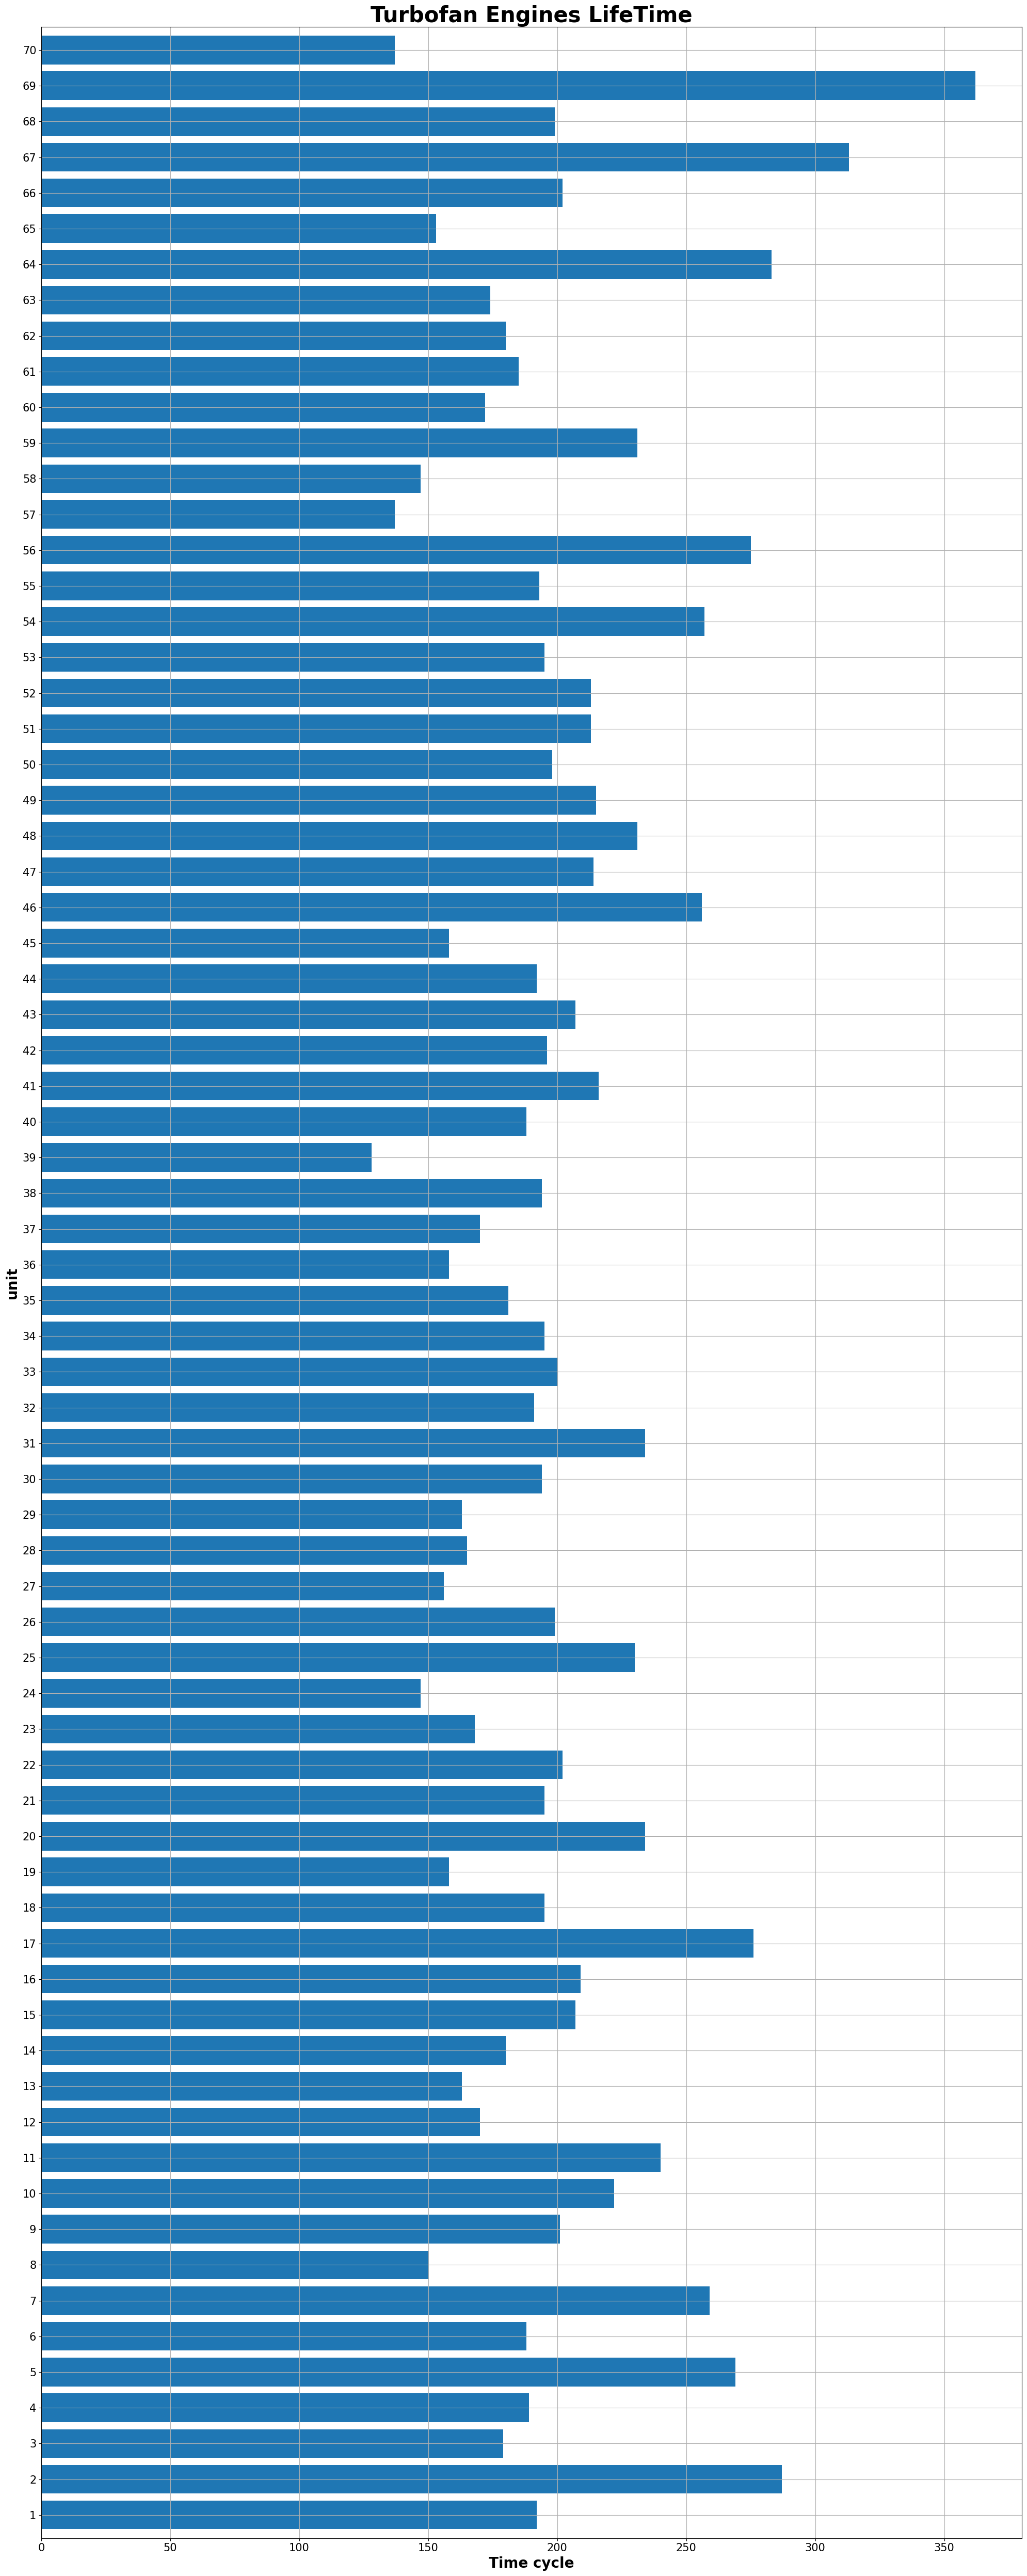

In [12]:
max_time_cycles=train[index_names].groupby('unit_number').max()  # unit_number = Index of Jet Engine (dataset 1 : 1~100)
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'max time cycle')

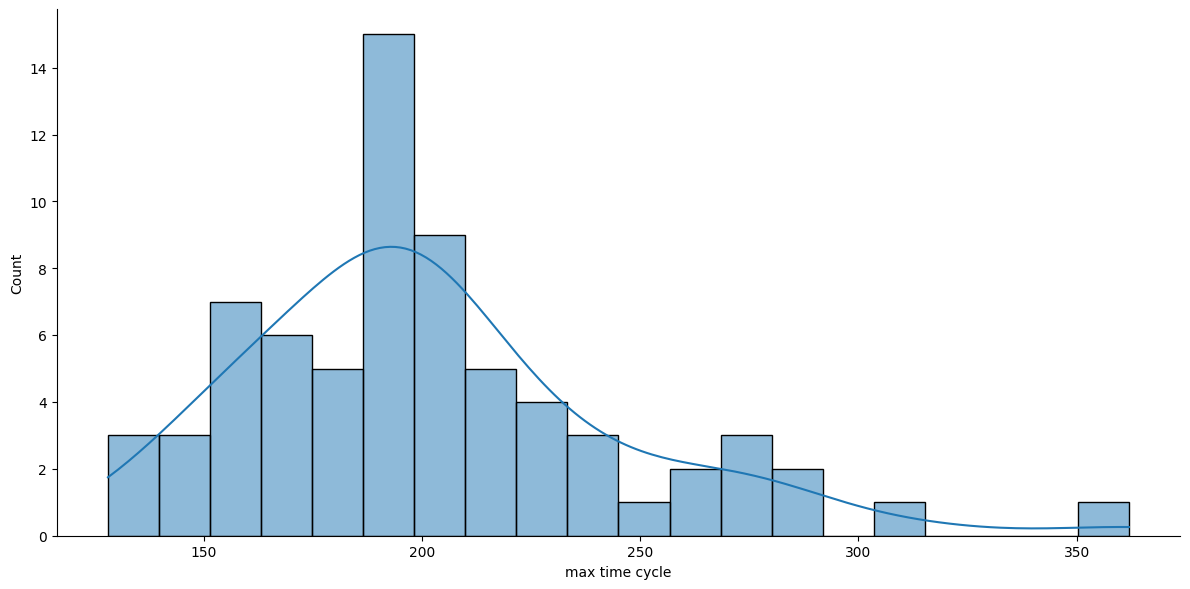

In [13]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it falls.

In [14]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [64]:
train = add_RUL_column(train)
valid = add_RUL_column(valid)
full_data = add_RUL_column(full_data)

In [16]:
train[['unit_number','RUL']] # Jet Engine 1~70 (total : 70)

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
14125           70    4
14126           70    3
14127           70    2
14128           70    1
14129           70    0

[14130 rows x 2 columns]

In [17]:
valid[['unit_number','RUL']] # Jet Engine 71~100 (total : 30)

unit_number  RUL
0              71  207
1              71  206
2              71  205
3              71  204
4              71  203
...           ...  ...
6496          100    4
6497          100    3
6498          100    2
6499          100    1
6500          100    0

[6501 rows x 2 columns]

In [65]:
full_data[['unit_number', 'RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [18]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

Plotting the evolution of features (sensors) along with the evolution with RUL

In [19]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
      #plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())
       if (i % 5 == 0):   #For a better visualisation, we plot the sensors signals of 10 units only (data : FD001)
           plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero  # xlim() : range of x-axis
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

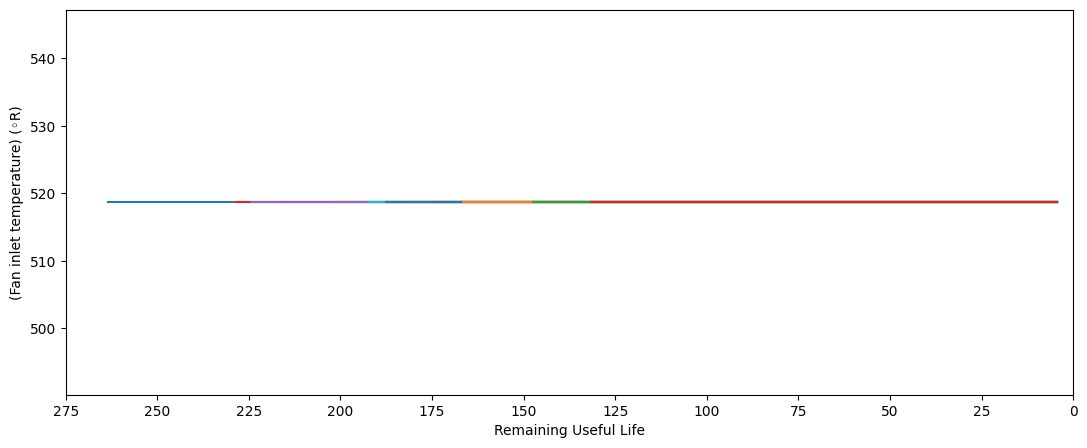

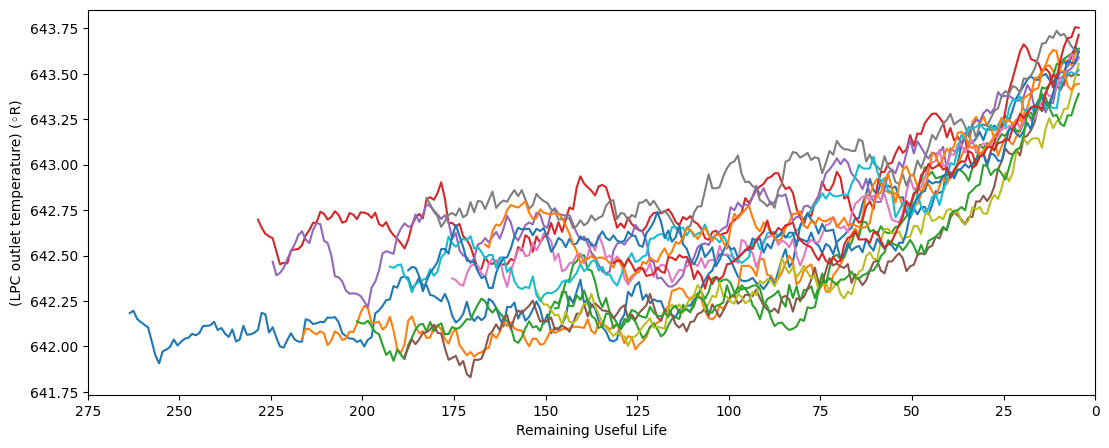

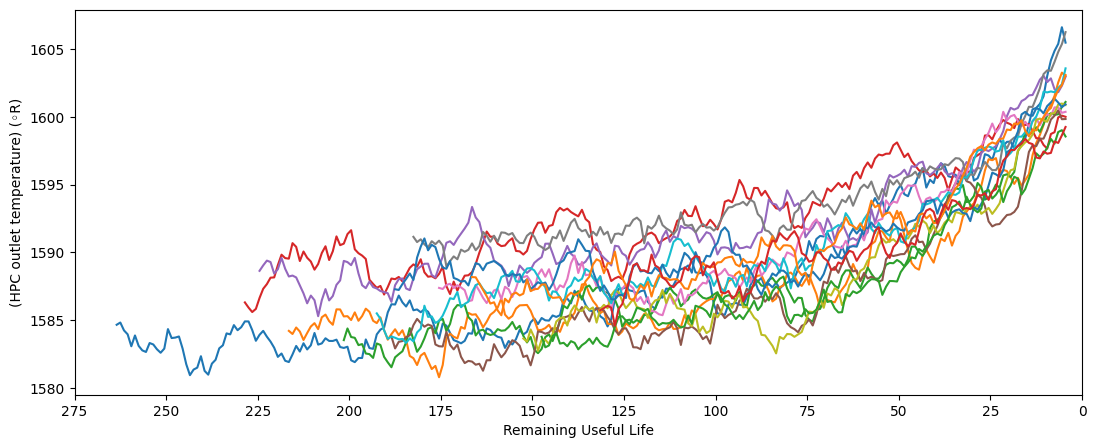

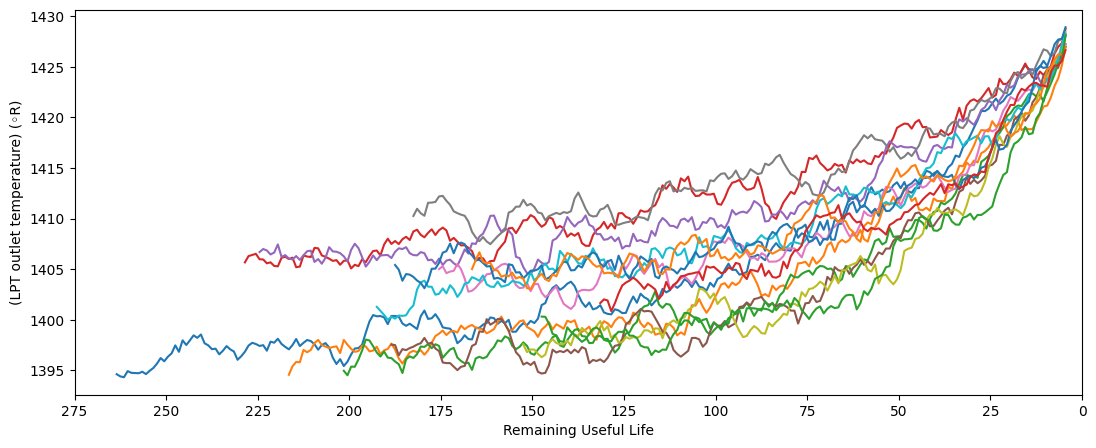

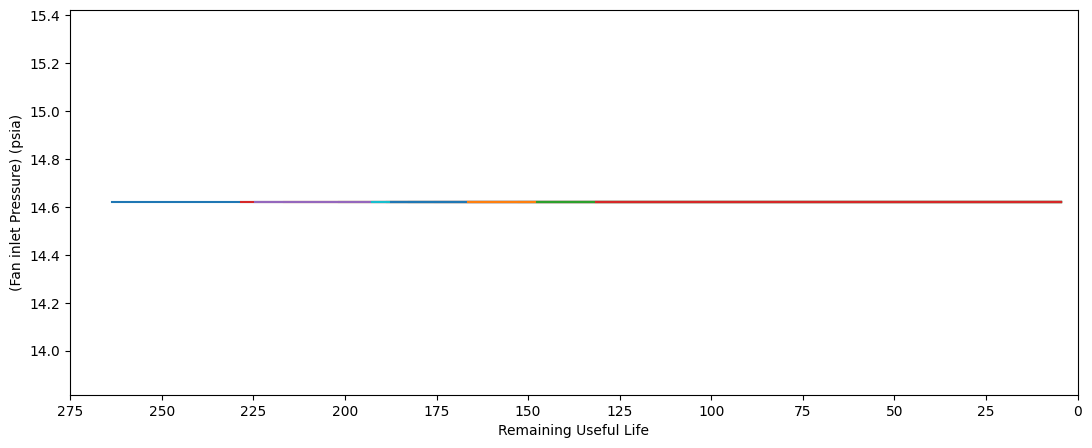

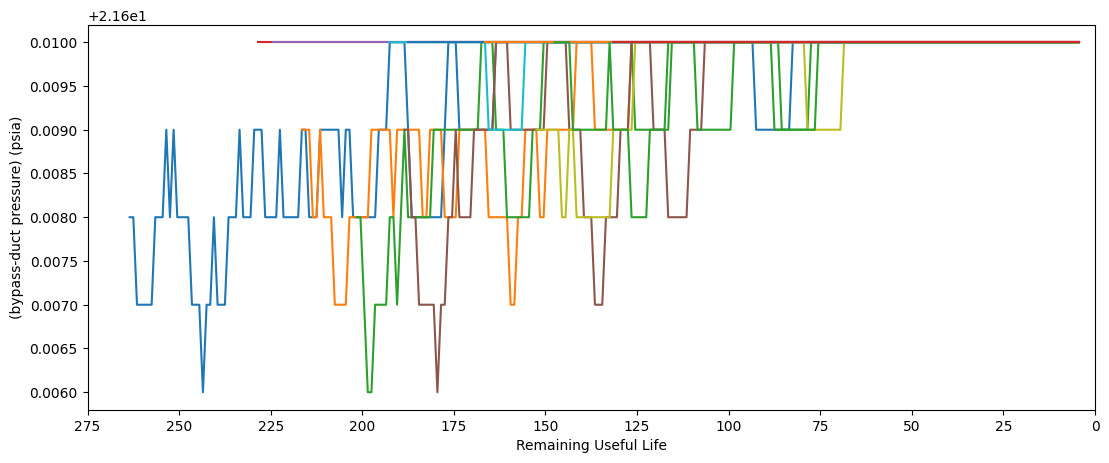

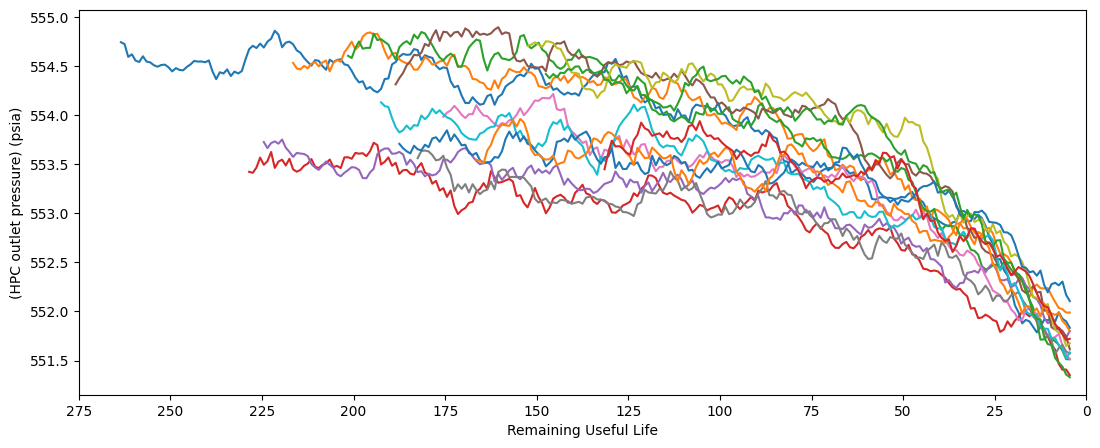

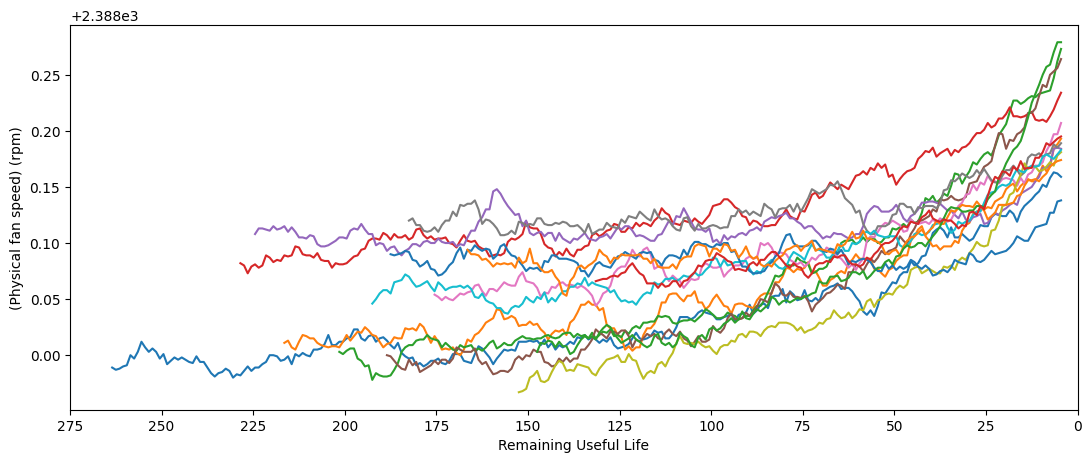

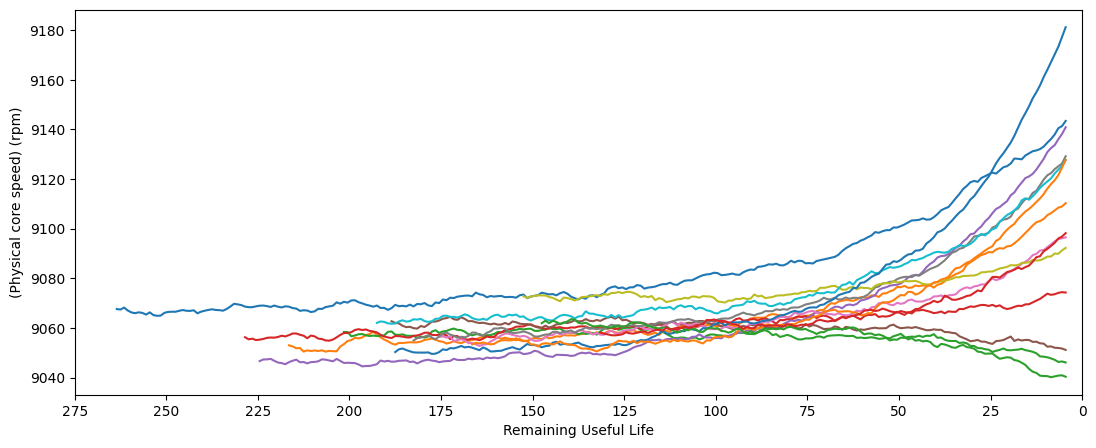

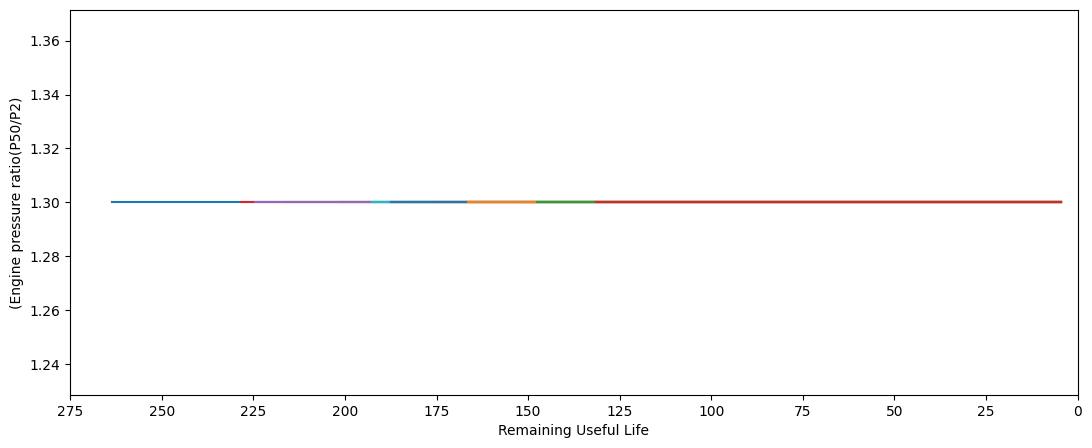

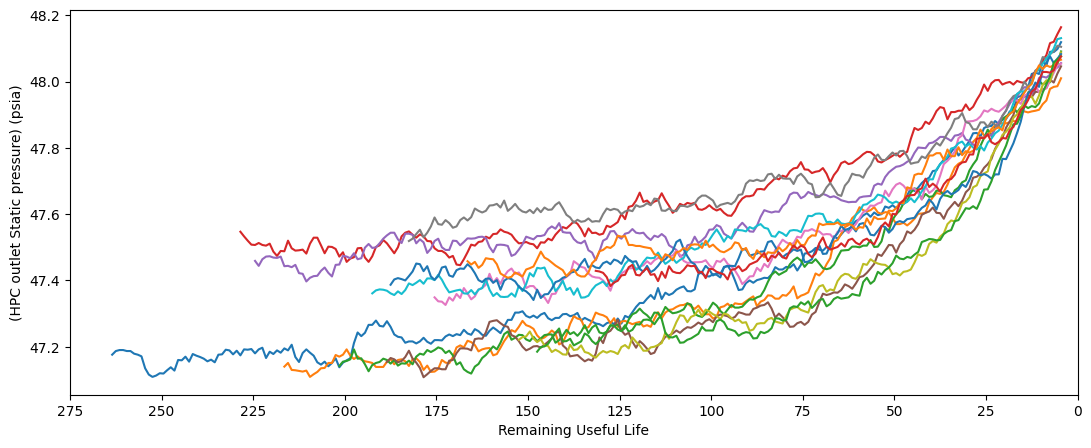

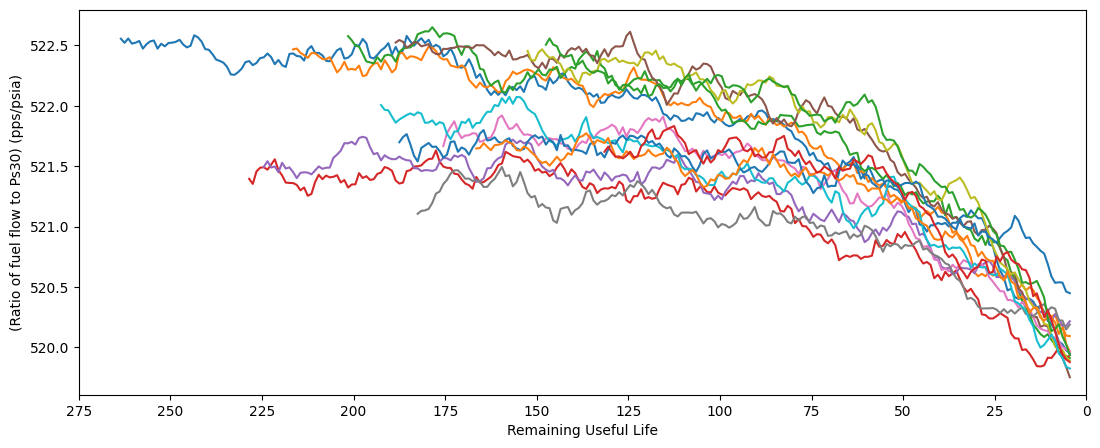

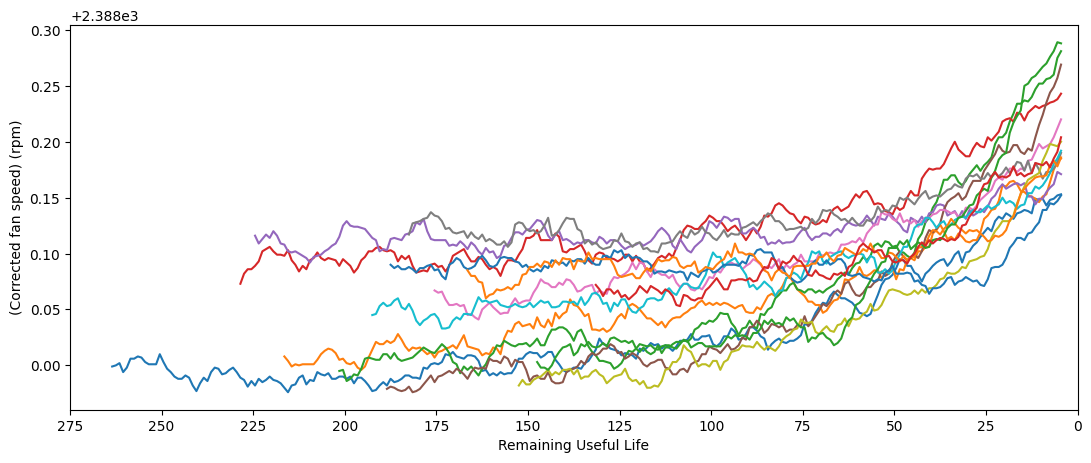

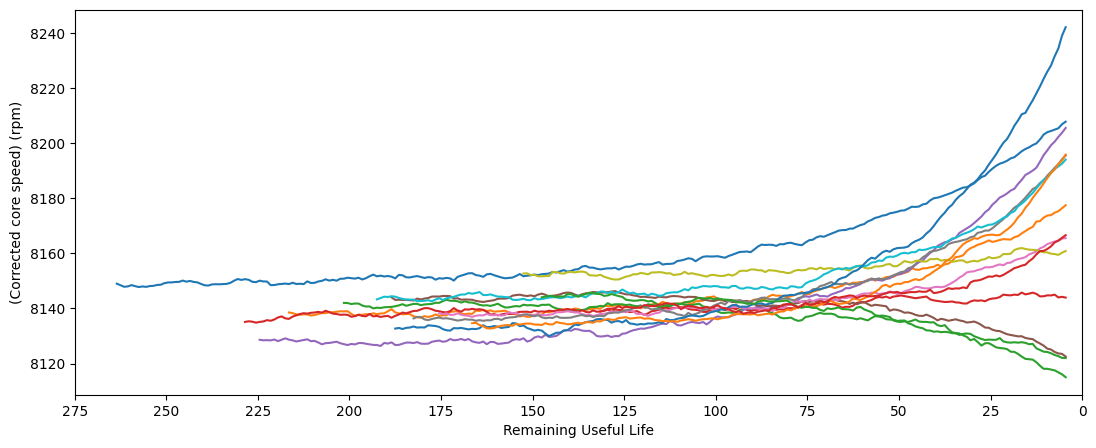

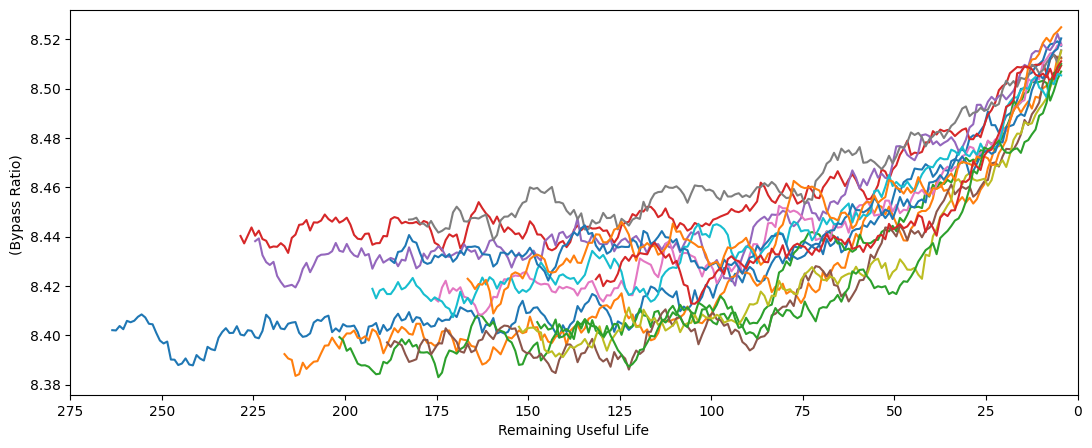

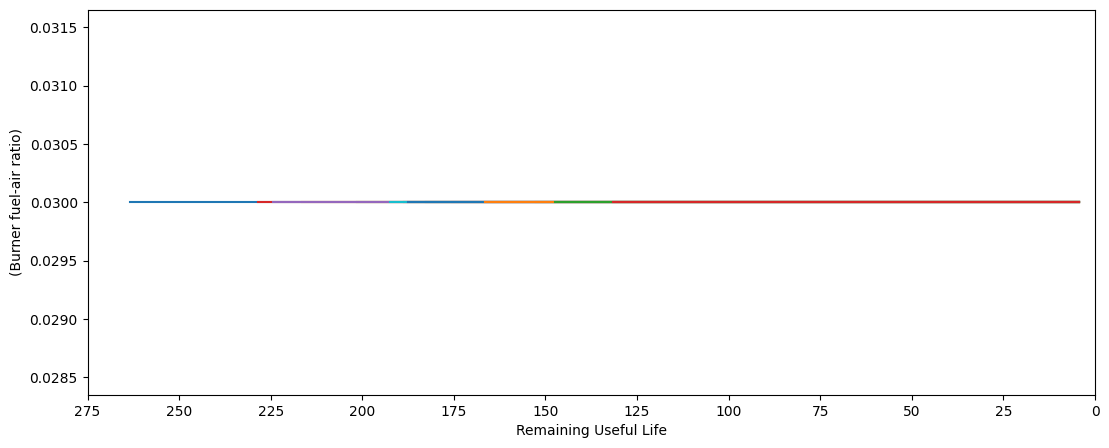

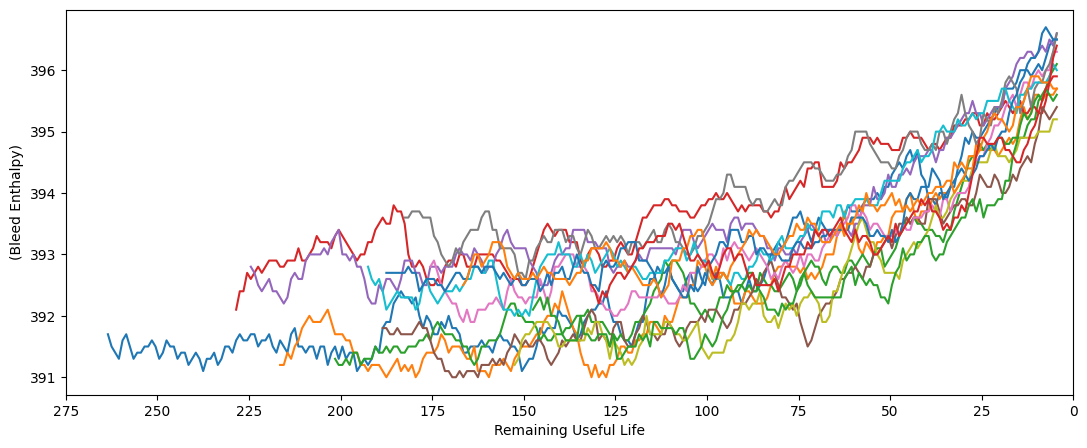

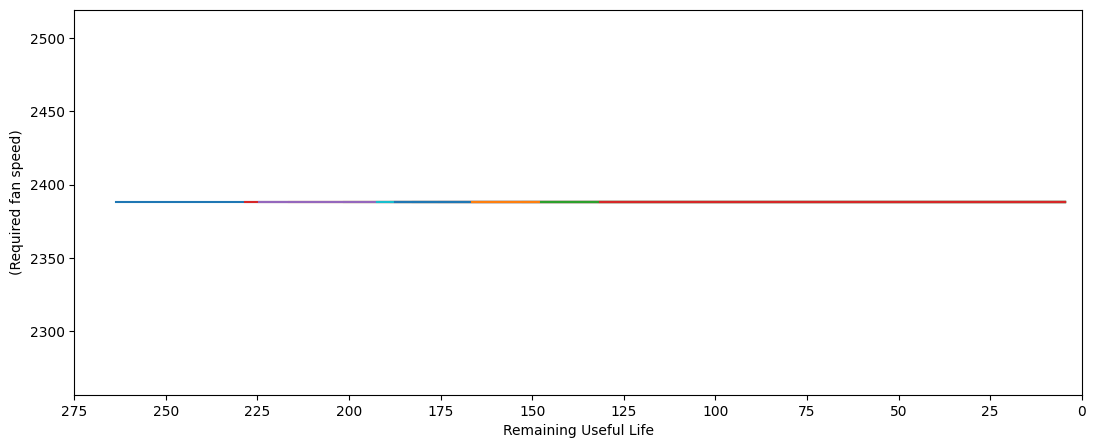

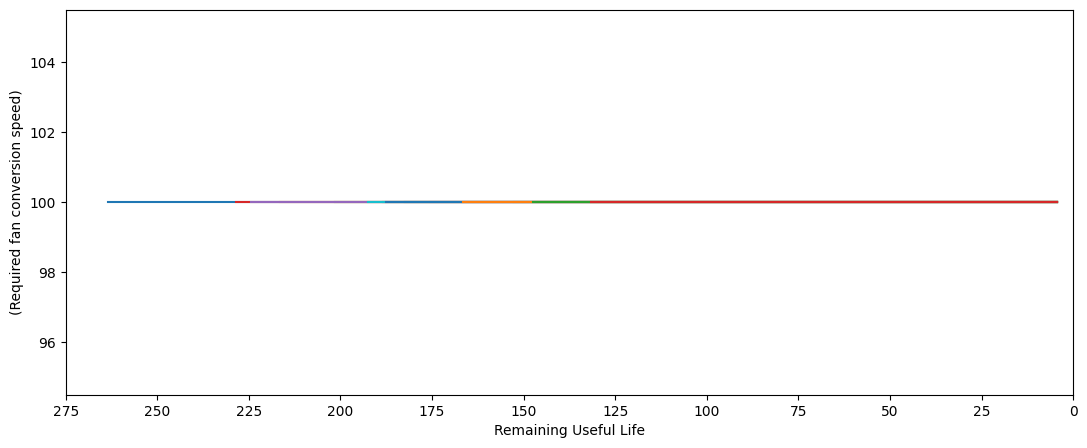

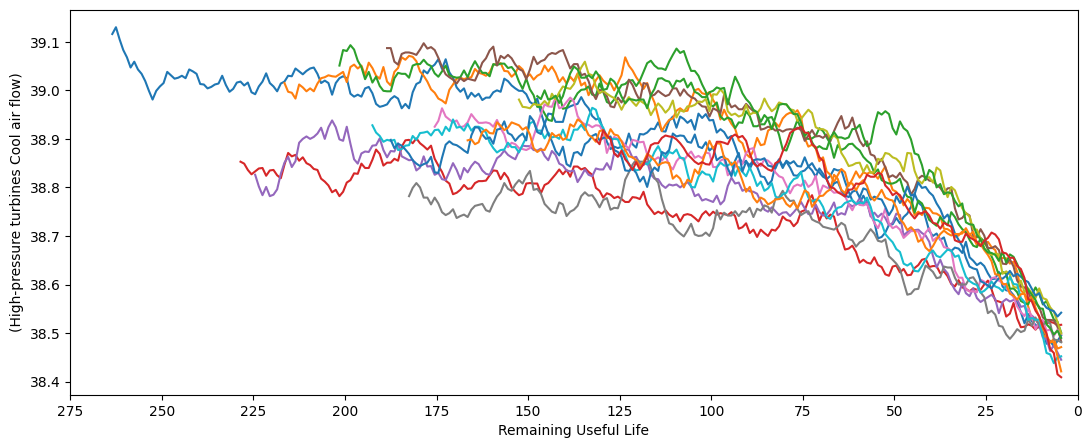

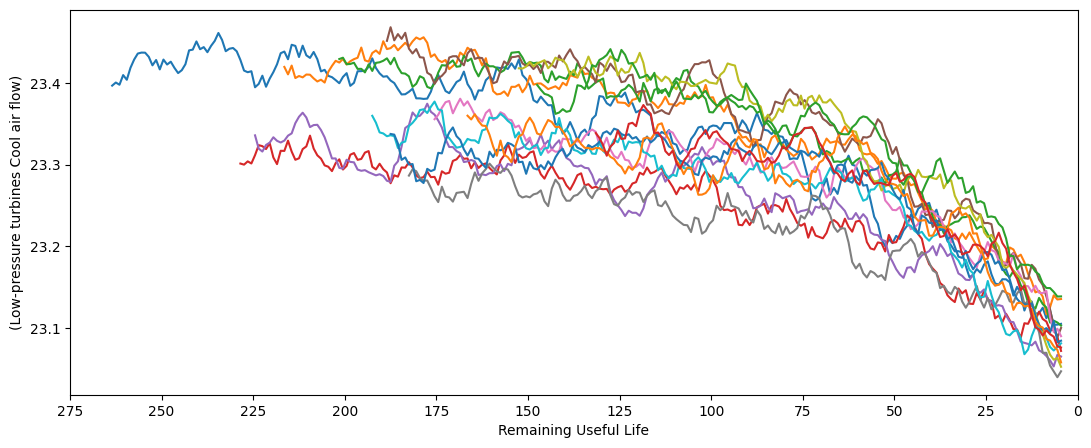

In [20]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

In [21]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%         50%  \
s_1   14130.0   518.670000  0.000000e+00   518.6700   518.6700   518.67000   
s_2   14130.0   642.679557  5.023198e-01   641.2100   642.3200   642.64000   
s_3   14130.0  1590.525633  6.147556e+00  1571.0400  1586.2400  1590.10000   
s_4   14130.0  1408.863436  8.996052e+00  1386.4300  1402.2900  1407.94000   
s_5   14130.0    14.620000  3.552839e-15    14.6200    14.6200    14.62000   
s_6   14130.0    21.609793  1.422661e-03    21.6000    21.6100    21.61000   
s_7   14130.0   553.378678  8.892235e-01   549.8500   552.8100   553.45000   
s_8   14130.0  2388.094212  7.082073e-02  2387.9000  2388.0400  2388.09000   
s_9   14130.0  9066.736406  2.302779e+01  9021.7300  9054.0900  9061.52000   
s_10  14130.0     1.300000  2.220525e-16     1.3000     1.3000     1.30000   
s_11  14130.0    47.539013  2.677363e-01    46.8600    47.3400    47.51000   
s_12  14130.0   521.422984  7.379826e-01   518.6900   520.9600   521.49000   
s_13  14130.0  2388.093695  7.186739e-02  2387.8800  2388.0400  2388.09000   
s_14  14130.0  8145.134132  1.986630e+01  8102.8200  8134.3525  8141.45000   
s_15  14130.0     8.441998  3.756531e-02     8.3279     8.4147     8.43900   
s_16  14130.0     0.030000  1.040871e-17     0.0300     0.0300     0.03000   
s_17  14130.0   393.212810  1.556883e+00   388.0000   392.0000   393.00000   
s_18  14130.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.00000   
s_19  14130.0   100.000000  0.000000e+00   100.0000   100.0000   100.00000   
s_20  14130.0    38.817253  1.809565e-01    38.1600    38.7000    38.83000   
s_21  14130.0    23.290124  1.086214e-01    22.9071    23.2227    23.29805   
RUL   14130.0   105.003609  6.666673e+01     0.0000    50.0000   100.00000   

              75%        max  
s_1    518.670000   518.6700  
s_2    643.010000   644.5300  
s_3   1594.400000  1614.9300  
s_4   1414.510000  1441.4900  
s_5     14.620000    14.6200  
s_6     21.610000    21.6100  
s_7    554.030000   556.0600  
s_8   2388.140000  2388.5600  
s_9   9070.770000  9244.5900  
s_10     1.300000     1.3000  
s_11    47.700000    48.5300  
s_12   521.960000   523.3800  
s_13  2388.140000  2388.5600  
s_14  8149.510000  8293.7200  
s_15     8.465500     8.5848  
s_16     0.030000     0.0300  
s_17   394.000000   399.0000  
s_18  2388.000000  2388.0000  
s_19   100.000000   100.0000  
s_20    38.950000    39.4300  
s_21    23.367575    23.6127  
RUL    152.000000   361.0000

MinMax scaler function : Transform features by scaling each feature to a given range.

This estimater scales and translates each feature individually such that it is in the given range on the training set

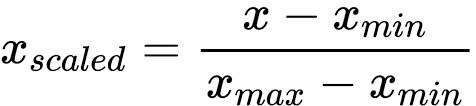

Dropping unnecessary features (labels and settings)

In [66]:
# 임시 코드
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names

# index_name을 split해서 보관해뒀다가 추후에 병합해줘야 RL에 적용할 수 있음
X_train_index_names = train[['unit_number', 'time_cycles']]
X_train = train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['RUL'], test_size = 0.01, random_state = 42, shuffle = False)

# Valid 코드도 수정해야 LR 가능함. ################################
# Valid data : engine 71~100
X_valid_index_names = valid[['unit_number','time_cycles']]
y_valid = valid[['RUL']]
X_valid = valid.drop(columns=drop_labels).copy()

X_full_index_names = full_data[['unit_number','time_cycles']]
y_full = full_data[['RUL']]
X_full = full_data.drop(columns=drop_labels).copy()

Test Code

In [23]:
print(y_train)
print(X_train)

0        191
1        190
2        189
3        188
4        187
        ... 
13983      9
13984      8
13985      7
13986      6
13987      5
Name: RUL, Length: 13988, dtype: int64
          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
13983  518.67  643.73  1598.88  1425.36  14.62  21.61  551.97  2388.25   
13984  518.67  643.66  1606.28  1430.15  14.62  21.61  550.34  2388.25   
13985  518.67  643.34  1593.05  1425.27  14.62  21.61  551.62  2388.24   
13986  518.67  643.19  1605.11  1428.43  14.62  21.61  551.02  2388.25   
1398

In [24]:
print(y_valid)
print(X_valid)

      RUL
0     207
1     206
2     205
3     204
4     203
...   ...
6496    4
6497    3
6498    2
6499    1
6500    0

[6501 rows x 1 columns]
         s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0     518.67  642.64  1581.95  1407.04  14.62  21.61  553.56  2388.11   
1     518.67  642.82  1593.17  1403.53  14.62  21.61  553.22  2388.11   
2     518.67  642.50  1582.94  1402.54  14.62  21.61  553.70  2388.11   
3     518.67  643.04  1584.90  1409.75  14.62  21.61  554.30  2388.14   
4     518.67  642.00  1587.63  1400.43  14.62  21.61  553.49  2388.09   
...      ...     ...      ...      ...    ...    ...     ...      ...   
6496  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19   
6497  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23   
6498  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24   
6499  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25   
6500  518.67  643.85  1600.38  1432.14  14.62  21.61

Scaling the data

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  # MinMaxScaler

#Droping the target variable (True RUL)
X_train.drop(columns=['RUL'], inplace=True) # inplace -> true면 원본 삭제 (current option)  # inplace -> False면 원본은 유지

#Scaling X_train
X_train_s=scaler.fit_transform(X_train)

#Conserve only the last occurence of each unit to match the length of y_valid
#X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

X_valid.drop(columns=['RUL'], inplace=True)
X_valid_s = scaler.transform(X_valid)

X_full.drop(columns=['RUL'], inplace=True)
X_full_s = scaler.transform(X_full)
#scaling X_valid
#X_valid_s=scaler.fit_transform(X_valid)

#fit_transform() : for train data ; transform() : for test data

In [26]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
13983  518.67  643.73  1598.88  1425.36  14.62  21.61  551.97  2388.25   
13984  518.67  643.66  1606.28  1430.15  14.62  21.61  550.34  2388.25   
13985  518.67  643.34  1593.05  1425.27  14.62  21.61  551.62  2388.24   
13986  518.67  643.19  1605.11  1428.43  14.62  21.61  551.02  2388.25   
13987  518.67  643.86  1601.80  1428.18  14.62  21.61  550.53  2388.25   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0      9046.19   1.3  ...  521

In [27]:
print(X_train_s)

[[0.         0.18373494 0.42515379 ... 0.         0.70866142 0.72548186]
 [0.         0.28313253 0.47345637 ... 0.         0.66141732 0.73200113]
 [0.         0.34337349 0.38619275 ... 0.         0.62204724 0.61947279]
 ...
 [0.         0.64156627 0.50148098 ... 0.         0.26771654 0.07993197]
 [0.         0.59638554 0.77625883 ... 0.         0.21259843 0.24050454]
 [0.         0.79819277 0.70084302 ... 0.         0.31496063 0.3064059 ]]


In [28]:
print(X_valid_s.shape)
print(y_valid.shape)
print(X_valid)
print(X_valid_s)

(6501, 21)
(6501, 1)
         s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0     518.67  642.64  1581.95  1407.04  14.62  21.61  553.56  2388.11   
1     518.67  642.82  1593.17  1403.53  14.62  21.61  553.22  2388.11   
2     518.67  642.50  1582.94  1402.54  14.62  21.61  553.70  2388.11   
3     518.67  643.04  1584.90  1409.75  14.62  21.61  554.30  2388.14   
4     518.67  642.00  1587.63  1400.43  14.62  21.61  553.49  2388.09   
...      ...     ...      ...      ...    ...    ...     ...      ...   
6496  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19   
6497  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23   
6498  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24   
6499  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25   
6500  518.67  643.85  1600.38  1432.14  14.62  21.61  550.79  2388.26   

          s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0     9042.70   1.3  .

In [29]:
print(y_valid)

      RUL
0     207
1     206
2     205
3     204
4     203
...   ...
6496    4
6497    3
6498    2
6499    1
6500    0

[6501 rows x 1 columns]


Plotting features new distribution

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

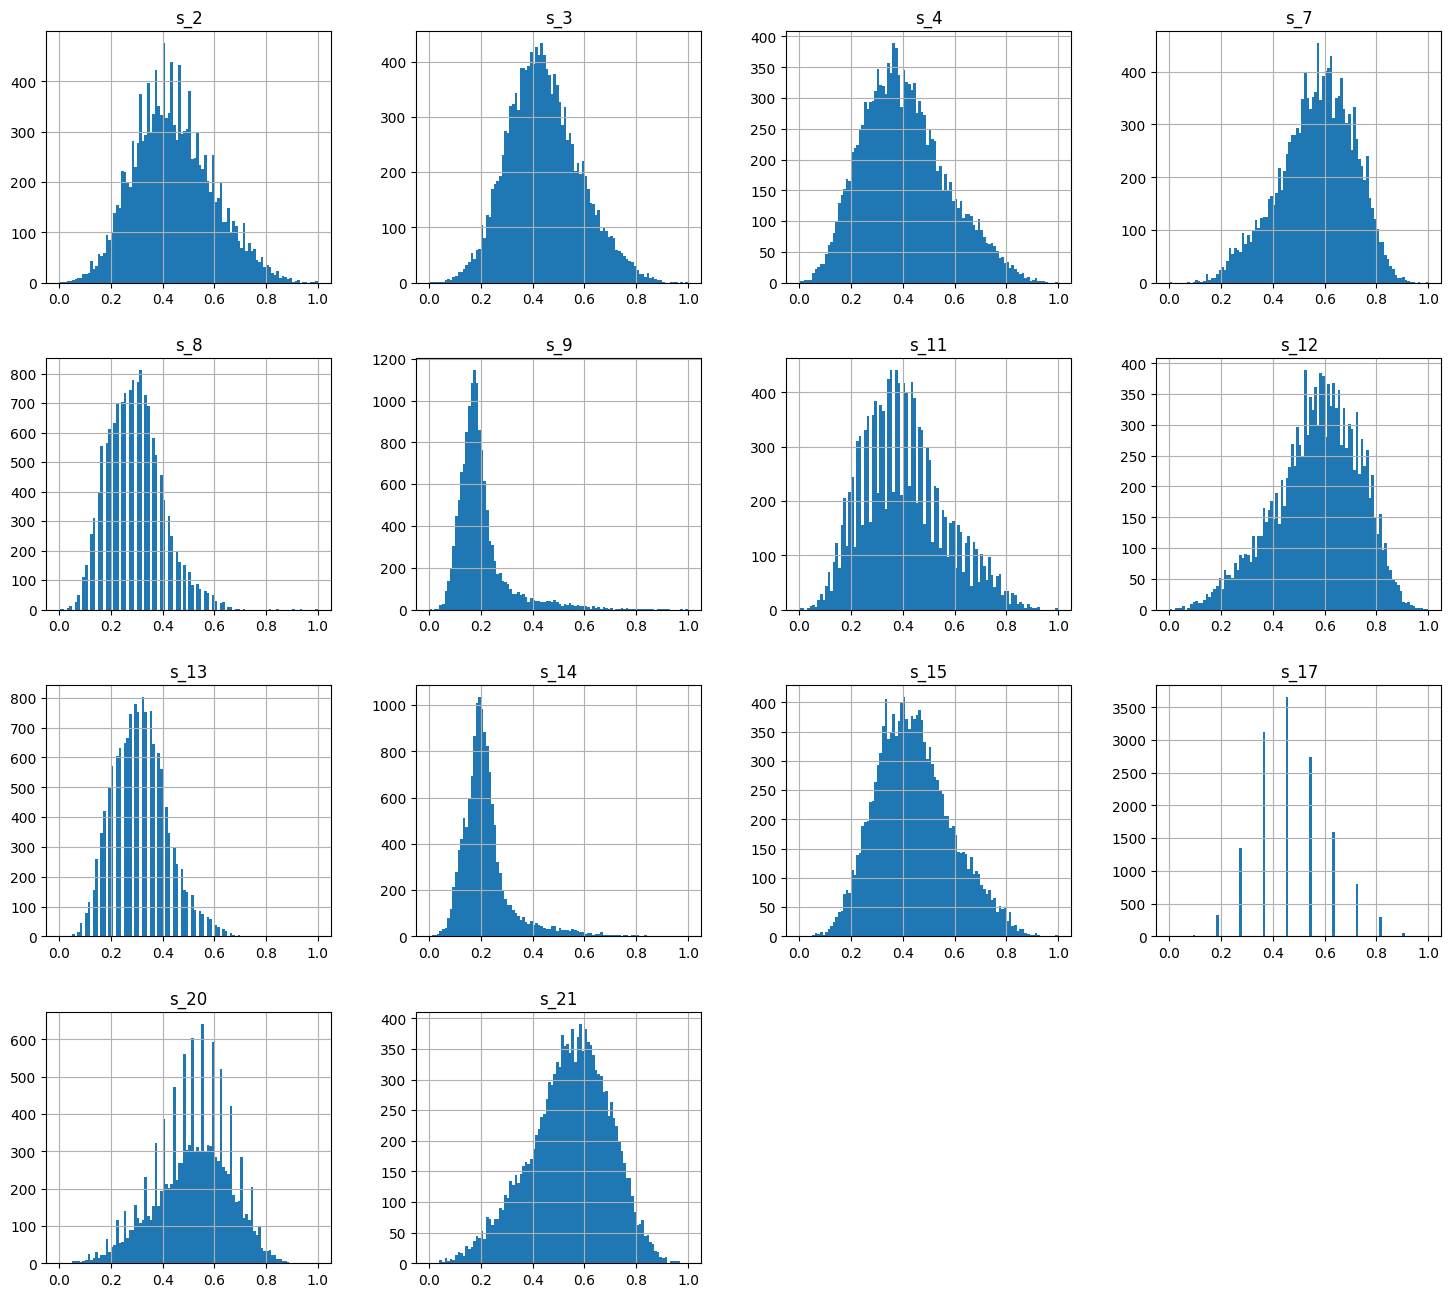

In [30]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

# Model Implementation

Linear regression

In [31]:
"""
# 1. Original Linear Regression (gradient learning)
class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=300 ) :
        self.lr = lr
        self.iterations = iterations
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p ) # w : 0
        self.b = 0                  # b : 0
        self.X = X
        self.Y = Y
        # gradientlearning
        for i in range( self.iterations ) :
            self.weight_updater()
        return

    def weight_updater( self ) :
        Y_pred = self.predict( self.X )
        #  gradients
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self

    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b
"""

'\n# 1. Original Linear Regression (gradient learning)\nclass Linear_Regression() :\n    def __init__( self, lr=0.01, iterations=300 ) :\n        self.lr = lr\n        self.iterations = iterations\n    def fit( self, X, Y ) :\n        self.l, self.p = X.shape\n        # weight initializer\n        self.W = np.zeros( self.p ) # w : 0\n        self.b = 0                  # b : 0\n        self.X = X\n        self.Y = Y\n        # gradientlearning\n        for i in range( self.iterations ) :\n            self.weight_updater()\n        return\n\n    def weight_updater( self ) :\n        Y_pred = self.predict( self.X )\n        #  gradients\n        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l\n        db = - 2 * np.sum( self.Y - Y_pred ) / self.l\n        # new weights assigned\n        self.b = self.b - self.lr * db\n        self.W = self.W - self.lr * dW\n        return self\n\n    def predict( self, X ) :\n          # Y_pr=X.W+b\n        return X.dot( self.W ) + self.b\n'

Support Vector Regression (SVR)

In [32]:
from sklearn.svm import SVR
import tensorflow as tf
regressor = SVR(kernel='rbf')

Random forest

In [33]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

Defining evaluation functions

In [34]:
# R2 score & RMSE & MSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat) # R2 score (R-squared) : indep. var.이 depend. var.을 얼마나 잘 설명하는가 (회귀모델 평가지표)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [35]:
# plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6                                # width
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values] # y : RUL
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

**Use all feature**

In [36]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_valid :  RUL    340
dtype: int64


In [37]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
13983  518.67  643.73  1598.88  1425.36  14.62  21.61  551.97  2388.25   
13984  518.67  643.66  1606.28  1430.15  14.62  21.61  550.34  2388.25   
13985  518.67  643.34  1593.05  1425.27  14.62  21.61  551.62  2388.24   
13986  518.67  643.19  1605.11  1428.43  14.62  21.61  551.02  2388.25   
13987  518.67  643.86  1601.80  1428.18  14.62  21.61  550.53  2388.25   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0      9046.19   1.3  ...  521

(array([1020., 1020., 1020., 1019.,  921.,  725.,  384.,  221.,  106.,
          65.]),
 array([  0.,  34.,  68., 102., 136., 170., 204., 238., 272., 306., 340.]),
 <BarContainer object of 10 artists>)

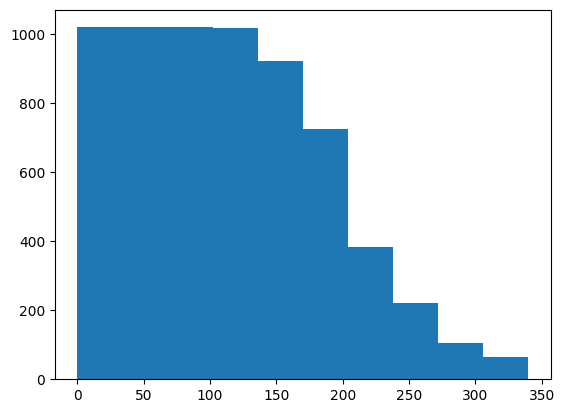

In [38]:
plt.hist(y_valid)

In [39]:
"""
drop_labels1=['s_1','s_2','s_5','s_6','s_8','s_9','s_10','s_11',
              's_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21']
# drop -> axis : {0 or 'index', 1 or 'columns'}, default 0;
#         columns : axis (labels, axis = 1 is equivalent to index = labels)

# Drop labels
X_train_1=X_train.drop(columns=drop_labels1, axis=1) # drop the constant columns from the train dataset (because, axis = 1)
X_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1

y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)

X_valid_1=X_valid.drop(columns=drop_labels1, axis=1)  # drop the constant columns from the validation dataset
X_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1
"""

"\ndrop_labels1=['s_1','s_2','s_5','s_6','s_8','s_9','s_10','s_11',\n              's_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21']\n# drop -> axis : {0 or 'index', 1 or 'columns'}, default 0;\n#         columns : axis (labels, axis = 1 is equivalent to index = labels)\n\n# Drop labels\nX_train_1=X_train.drop(columns=drop_labels1, axis=1) # drop the constant columns from the train dataset (because, axis = 1)\nX_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1\n\ny_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)\n\nX_valid_1=X_valid.drop(columns=drop_labels1, axis=1)  # drop the constant columns from the validation dataset\nX_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1\n"

In [68]:
X_train_1=X_train
X_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1

y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)

X_valid_1=X_valid
X_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1

X_full_1=X_full
X_full_1_s=scaler.fit_transform(X_full_1) #scaling X_valid_1


**Linear regression**

In [70]:
print(X_train_1_s)
print(X_train_1_s.shape)
print(X_valid_1_s)
print(X_valid_1_s.shape)
print(X_full_1_s)
print(X_full_1_s.shape)

[[0.         0.18373494 0.42515379 ... 0.         0.70866142 0.72548186]
 [0.         0.28313253 0.47345637 ... 0.         0.66141732 0.73200113]
 [0.         0.34337349 0.38619275 ... 0.         0.62204724 0.61947279]
 ...
 [0.         0.64156627 0.50148098 ... 0.         0.26771654 0.07993197]
 [0.         0.59638554 0.77625883 ... 0.         0.21259843 0.24050454]
 [0.         0.79819277 0.70084302 ... 0.         0.31496063 0.3064059 ]]
(13988, 21)
[[0.         0.44267516 0.23751363 ... 0.         0.72649573 0.47735432]
 [0.         0.5        0.48222465 ... 0.         0.60683761 0.54473902]
 [0.         0.39808917 0.25910578 ... 0.         0.66666667 0.65258216]
 ...
 [0.         0.6910828  0.68484188 ... 0.         0.25641026 0.05399061]
 [0.         0.63057325 0.74591058 ... 0.         0.12820513 0.23446562]
 [0.         0.82802548 0.63947655 ... 0.         0.1965812  0.21817178]]
(6501, 21)
[[0.         0.18373494 0.40680183 ... 0.         0.71317829 0.7246617 ]
 [0.         0.2

In [71]:
print(y_train_clip)
print(y_train_clip.shape)

0        191
1        190
2        189
3        188
4        187
        ... 
13983      9
13984      8
13985      7
13986      6
13987      5
Name: RUL, Length: 13988, dtype: int64
(13988,)


# **Loss function Tuning**

**1. Original MSE**

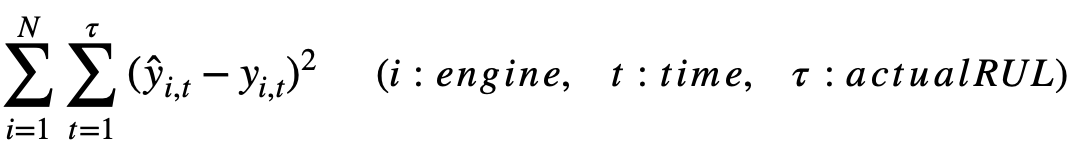

In [73]:
# 1. Original Linear Regression (모든 데이터 사용)
lr1 = LinearRegression()

lr1.fit(X_train_1_s, y_train_clip) #Fitting

y_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_1, label='train')

y_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_1, label='valid')

y_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_1, label='full data')

train set RMSE:35.40922753347836, R2:0.6485238516629761
valid set RMSE:51.37473626828611, R2:0.505982981636631
full data set RMSE:45.495829971288735, R2:0.5637198313471796


**2. Crucial moments Loss function**

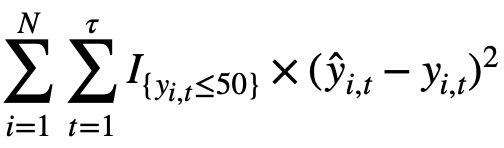

In [75]:
# 2. Crucial moments loss function - Linear Regression

# Filter and save only data that is less than 50.
filtered_data = X_train_1_s[y_train_clip <= 50]
filtered_labels = y_train_clip[y_train_clip <= 50]

lr2 = LinearRegression()

lr2.fit(filtered_data, filtered_labels) #Fitting

y_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_2, label='train')

y_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_2, label='valid')

y_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_2, label='full data')

train set RMSE:71.57127730270611, R2:-0.4359538729900654
valid set RMSE:93.56829895225663, R2:-0.6387026938773566
full data set RMSE:82.92629638371982, R2:-0.4494619765726149


**3. TD Style Loss function (Time smoothing)**

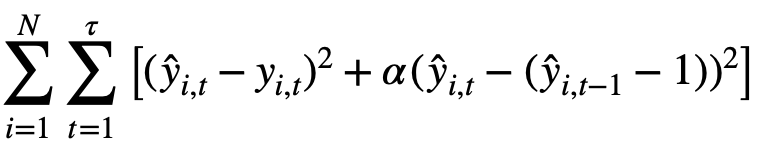

In [45]:
# 3. TD style loss function - Linear Regression (gradient learning) - quadratic form이므로 closed 형태가 존재함. gradient 안해도 결과는 같음.
class Linear_Regression_TD() :
    def __init__( self, alpha=0.1, iterations=100, lr=1 ) :
        self.lr = lr
        self.alpha = alpha
        self.iterations = iterations
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p ) # w : 0
        self.b = 0                  # b : 0
        self.X = X
        self.Y = Y

        for j in range( self.iterations ) :

        # gradientlearning
          for i in range( self.l ) :
            if i == 0:    # 처음 실행될 때 index error 방지
              continue
            Y_pred = self.predict( self.X[i])
            Y_pred_pre = self.predict( self.X[i-1])

            #  gradients # W, b는 index에 관계 없이 변수로 두고 편미분
            dW = ( 2 * (Y_pred - Y[i]) * X[i] + 2 * self.alpha * (Y_pred - (Y_pred_pre - 1)) * (X[i] - X[i-1]) ) / self.l
            db = ( 2 * (Y_pred - Y[i]) ) / self.l

            # new weights assigned
            self.W = self.W - self.lr * dW
            self.b = self.b - self.lr * db
        return

    def predict( self, X ) :
          # Y_pr=X.W+b

        return X.dot( self.W ) + self.b

In [76]:
lr3 = Linear_Regression_TD()

lr3.fit(X_train_1_s, y_train_clip) #Fitting

y_lr_train_3 = lr3.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_3, label='train')

y_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_3, label='valid')

y_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_3, label='full data')

train set RMSE:38.44787439599302, R2:0.5856115684118648
valid set RMSE:48.86652770575838, R2:0.5530430853074292
full data set RMSE:46.25998760255098, R2:0.5489410422402623


Merge!

In [47]:
# loss function 별 dataframe들을 list로 저장
y_lr_valid_dfs = [pd.DataFrame(y_lr_valid_1, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_2, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_3, columns=['predicted RUL'])]
merged_valid_dfs = []

# 각 dataframe에 병합하고 출력
for i, y_lr_valid_df in enumerate(y_lr_valid_dfs, start=1):
    merged_valid = pd.concat([X_valid_index_names, y_lr_valid_df, y_valid], axis=1)
    merged_valid_dfs.append(merged_valid)
    print(f"Merged Valid DataFrame {i}:\n", merged_valid)

Merged Valid DataFrame 1:
       unit_number  time_cycles  predicted RUL  RUL
0              71            1     128.139832  207
1              71            2     114.185208  206
2              71            3     126.227164  205
3              71            4     124.890579  204
4              71            5     129.597575  203
...           ...          ...            ...  ...
6496          100          196      -9.574165    4
6497          100          197     -12.522282    3
6498          100          198     -24.131772    2
6499          100          199     -30.700416    1
6500          100          200     -25.026533    0

[6501 rows x 4 columns]
Merged Valid DataFrame 2:
       unit_number  time_cycles  predicted RUL  RUL
0              71            1      50.632505  207
1              71            2      47.159429  206
2              71            3      51.407043  205
3              71            4      50.082682  204
4              71            5      54.343519  203
...

In [77]:
# loss function 별 dataframe들을 list로 저장
y_lr_full_dfs = [pd.DataFrame(y_lr_full_1, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_2, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_3, columns=['predicted RUL'])]
merged_full_dfs = []

# 각 dataframe에 병합하고 출력
for i, y_lr_full_df in enumerate(y_lr_full_dfs, start=1):
    merged_full = pd.concat([X_full_index_names, y_lr_full_df, y_full], axis=1)
    merged_full_dfs.append(merged_full)
    print(f"Merged full DataFrame {i}:\n", merged_full)

Merged full DataFrame 1:
        unit_number  time_cycles  predicted RUL  RUL
0                1            1     144.757877  191
1                1            2     141.685106  190
2                1            3     151.134776  189
3                1            4     166.481200  188
4                1            5     142.254493  187
...            ...          ...            ...  ...
20626          100          196       3.379686    4
20627          100          197       1.319660    3
20628          100          198      -9.675932    2
20629          100          199     -15.745414    1
20630          100          200     -10.547572    0

[20631 rows x 4 columns]
Merged full DataFrame 2:
        unit_number  time_cycles  predicted RUL  RUL
0                1            1      63.780923  191
1                1            2      62.025099  190
2                1            3      64.781917  189
3                1            4      69.143419  188
4                1            5      6

# Visualization

**(1) 각 엔진의 online predict value (test data 71~100)**

(X-axis : Time cycles, Y-axis : predicted RUL)

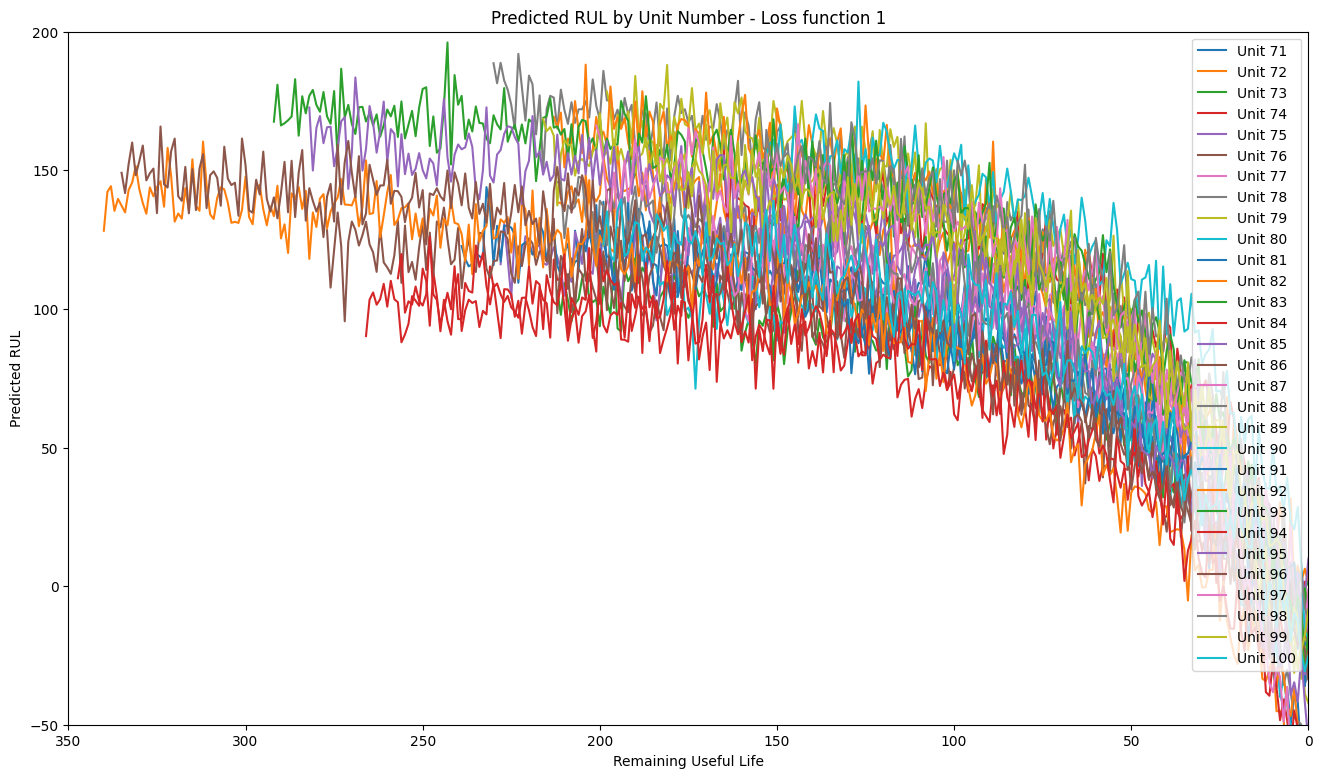

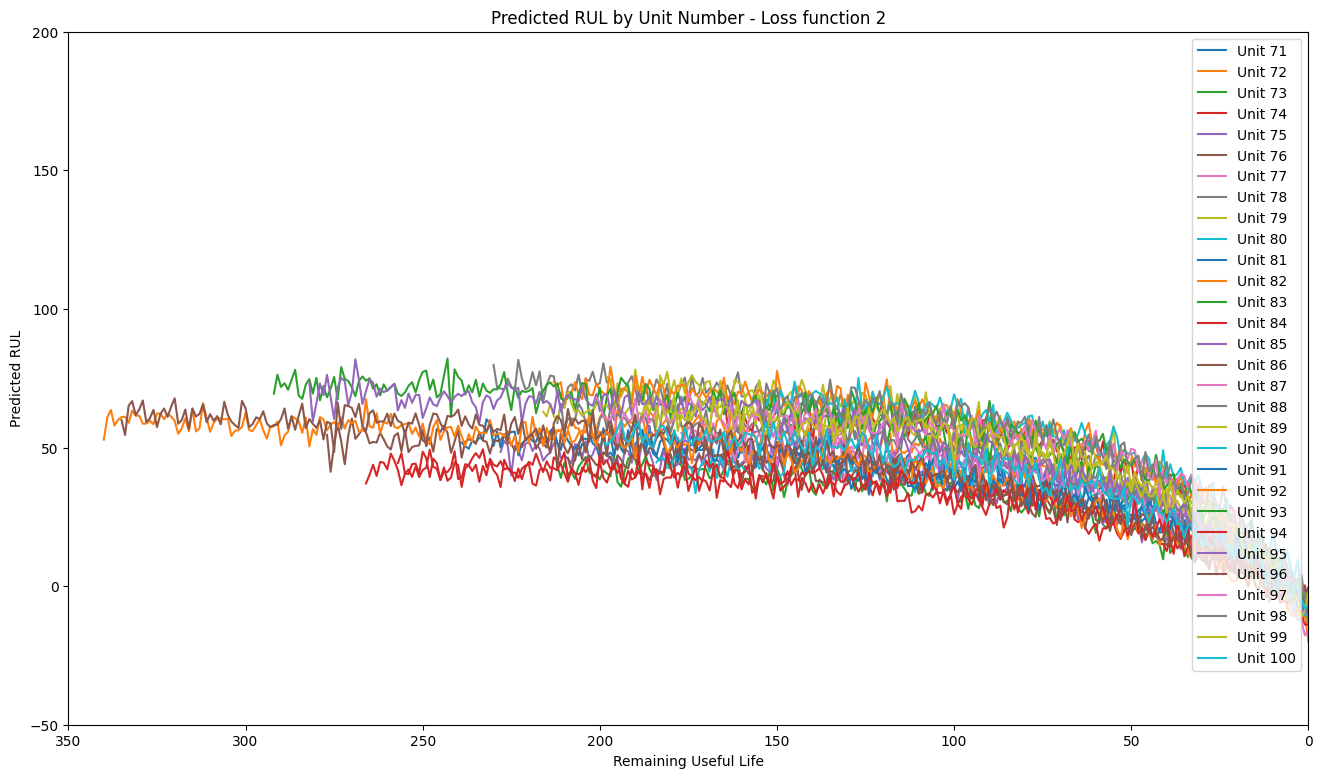

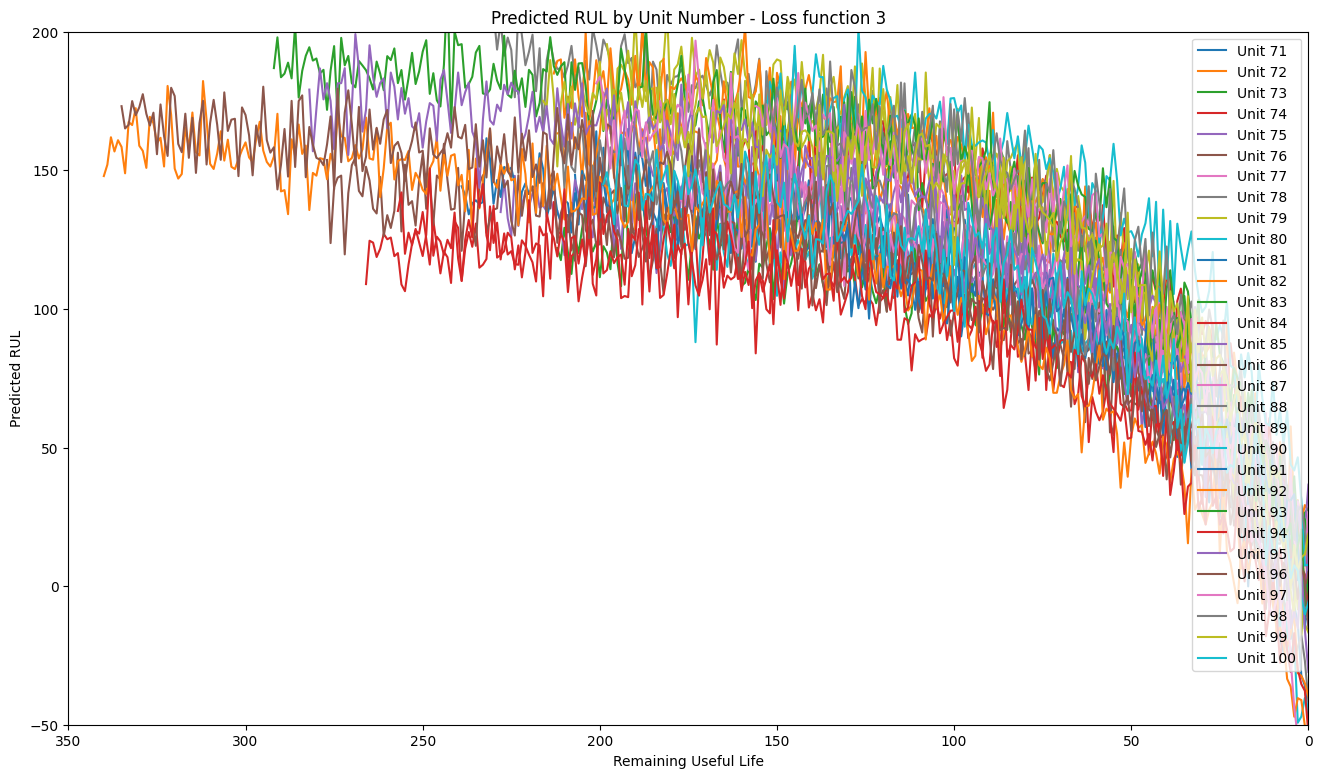

In [48]:
# merged_valid_dfs 리스트에 있는 데이터프레임들에 대해 반복 수행
for i, merged_valid_df in enumerate(merged_valid_dfs, start=1):
    # 데이터프레임에서 unit_number을 기준으로 그룹화
    grouped = merged_valid_df.groupby('unit_number')

    # 그래프를 그릴 subplot을 설정
    fig, ax = plt.subplots(figsize=(16, 9))

    # unit_number 별로 그래프 그리기
    for unit, group in grouped:
        ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

    ax.set_xlabel('Remaining Useful Life')
    ax.set_ylabel('Predicted RUL')
    ax.set_title(f'Predicted RUL by Unit Number - Loss function {i}')
    ax.legend(loc='upper right')  # 범례 추가

    # 그래프 출력 설정
    plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylim(-50, 200)
    plt.show()

**Threshold, Actual Operation Time**

**Add "Cumulative Operation Time", "Total Cost" Columns**


Cost : Failure (10,000), replace (100)

In [ ]:
# define list of threshold_value
threshold_start = -40
threshold_end = 30
threshold_values = list(range(threshold_start, threshold_end + 1))

# 각 threshold_value에 대한 dataframe을 담을 리스트를 생성.
by_threshold_dfs_list = []

# Define cost (Tentative Value)
REPLACE_COST = 100
FAILURE_COST = 10000

# merged_valid_dfs 리스트 내에 있는 각 데이터프레임에 대해 반복 수행
for merged_valid_df in merged_valid_dfs:
    by_threshold_dfs = []

    # threshold_value 별 처리.
    for threshold_value in threshold_values:

        cumulative_operation_time = 0
        total_cost = 0
        by_threshold_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])

        grouped = merged_valid_df.groupby('unit_number')

        for unit, group in grouped:
            operation_time = None

            for index, row in group.iterrows():
                if row['predicted RUL'] <= threshold_value:
                    operation_time = row['time_cycles']
                    cumulative_operation_time += operation_time
                    total_cost += REPLACE_COST
                    break

            max_RUL = group['RUL'].max()

            if pd.isna(operation_time):
                cumulative_operation_time += max_RUL
                total_cost += FAILURE_COST

            by_threshold_df = by_threshold_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                      'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                      'Total Cost': total_cost}, ignore_index=True)

        by_threshold_dfs.append(by_threshold_df)

    by_threshold_dfs_list.append(by_threshold_dfs)

"""
# 각 threshold_value에 대한 dataframe 출력 (수치 확인용).
for i, by_threshold_dfs in enumerate(by_threshold_dfs_list, start=2):
    print(f"DataFrames for merged_valid_df {i}:")
    for j, threshold_value in enumerate(threshold_values):
        print(f"DataFrame for threshold_value = {threshold_value}:")
        print(by_threshold_dfs[j])
        print()
"""

**Apply full data set**

In [78]:
# 각 threshold_value에 대한 dataframe을 담을 리스트를 생성.
full_by_threshold_dfs_list = []

# merged_full_dfs 리스트 내에 있는 각 데이터프레임에 대해 반복 수행
for merged_full_df in merged_full_dfs:
    full_by_threshold_dfs = []

    # threshold_value 별 처리.
    for threshold_value in threshold_values:

        cumulative_operation_time = 0
        total_cost = 0
        full_by_threshold_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])

        grouped = merged_full_df.groupby('unit_number')

        for unit, group in grouped:
            operation_time = None

            for index, row in group.iterrows():
                if row['predicted RUL'] <= threshold_value:
                    operation_time = row['time_cycles']
                    cumulative_operation_time += operation_time
                    total_cost += REPLACE_COST
                    break

            max_RUL = group['RUL'].max()

            if pd.isna(operation_time):
                cumulative_operation_time += max_RUL
                total_cost += FAILURE_COST

            full_by_threshold_df = full_by_threshold_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                      'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                      'Total Cost': total_cost}, ignore_index=True)

        full_by_threshold_dfs.append(full_by_threshold_df)

    full_by_threshold_dfs_list.append(full_by_threshold_dfs)

**(2) Threshold를 x축으로 두고 분석**

(x-axis : Threshold, y-axis : Number of replace failures)


(x-axis : Threshold, y-axis : Total Cost)

In [50]:
# Total operation time
TOTAL_OPERATION_TIME = 4700

# empty list를 생성, threshold와 count of NaN을 저장할 list 초기화.
# 정해진 operation time까지의 Total Cost를 저장할 list 초기화.
nan_counts_list = []
total_cost_list_list = []
last_index_list_list = []

# 각 by_threshold_dfs 리스트 내의 by_threshold_df에 대해 반복 수행
for by_threshold_dfs in by_threshold_dfs_list:
    nan_counts = []
    total_cost_list = []
    last_index_list = []

    # 각 dataframe마다 수행.
    for df in by_threshold_dfs:
        last_index = 0  # Cumulative operation time이 목표를 넘어선 index 저장
        last_index = df[df['Cumulative Operation Time'] > TOTAL_OPERATION_TIME].index[0] # Total operation time을 넘어서면 last_index에 저장.
        last_index_list.append(last_index)

        total_cost_by_threshold = df.loc[last_index, 'Total Cost']
        total_cost_list.append(total_cost_by_threshold) # Total cost들을 list에 저장

        # 'actual operation time' column의 NaN 개수 count 후 리스트에 추가. last index 까지만 Nan을 count.
        nan_count = df.loc[:last_index, 'actual operation time'].isna().sum()
        nan_counts.append(nan_count)

    nan_counts_list.append(nan_counts)
    total_cost_list_list.append(total_cost_list)
    last_index_list_list.append(last_index_list)

# 각 by_threshold_dfs 리스트 내에 대한 결과를 저장하는 데이터프레임 생성
nan_counts_and_cost_df_list = []
for i, by_threshold_dfs in enumerate(by_threshold_dfs_list, start=1):
    threshold_values = list(range(threshold_start, threshold_end + 1))
    nan_counts_and_cost_df = pd.DataFrame({'Threshold': threshold_values, 'Number of replace failures': nan_counts_list[i - 1],
                                           'Total Cost': total_cost_list_list[i - 1], 'Last index': last_index_list_list[i - 1]})
    nan_counts_and_cost_df_list.append(nan_counts_and_cost_df)
    print(f"DataFrame for merged_valid_df {i}:\n", nan_counts_and_cost_df)


DataFrame for merged_valid_df 1:
     Threshold  Number of replace failures  Total Cost  Last index
0         -40                          17    170600.0          22
1         -39                          17    170600.0          22
2         -38                          17    170600.0          22
3         -37                          17    170600.0          22
4         -36                          16    160700.0          22
..        ...                         ...         ...         ...
66         26                           0      2500.0          24
67         27                           0      2500.0          24
68         28                           0      2500.0          24
69         29                           0      2500.0          24
70         30                           0      2500.0          24

[71 rows x 4 columns]
DataFrame for merged_valid_df 2:
     Threshold  Number of replace failures  Total Cost  Last index
0         -40                          22    220000

**apply full data**

In [95]:
# Total operation time
FULL_TOTAL_OPERATION_TIME = 16500

# empty list를 생성, threshold와 count of NaN을 저장할 list 초기화.
# 정해진 operation time까지의 Total Cost를 저장할 list 초기화.
full_nan_counts_list = []
full_total_cost_list_list = []
full_last_index_list_list = []

# 각 by_threshold_dfs 리스트 내의 by_threshold_df에 대해 반복 수행
for full_by_threshold_dfs in full_by_threshold_dfs_list:
    full_nan_counts = []
    full_total_cost_list = []
    full_last_index_list = []

    # 각 dataframe마다 수행.
    for df in full_by_threshold_dfs:
        full_last_index = 0  # Cumulative operation time이 목표를 넘어선 index 저장
        full_last_index = df[df['Cumulative Operation Time'] > FULL_TOTAL_OPERATION_TIME].index[0] # Total operation time을 넘어서면 last_index에 저장.
        full_last_index_list.append(full_last_index)

        full_total_cost_by_threshold = df.loc[full_last_index, 'Total Cost']
        full_total_cost_list.append(full_total_cost_by_threshold) # Total cost들을 list에 저장

        # 'actual operation time' column의 NaN 개수 count 후 리스트에 추가. last index 까지만 Nan을 count.
        full_nan_count = df.loc[:full_last_index, 'actual operation time'].isna().sum()
        full_nan_counts.append(full_nan_count)

    full_nan_counts_list.append(full_nan_counts)
    full_total_cost_list_list.append(full_total_cost_list)
    full_last_index_list_list.append(full_last_index_list)

# 각 by_threshold_dfs 리스트 내에 대한 결과를 저장하는 데이터프레임 생성
full_nan_counts_and_cost_df_list = []
for i, full_by_threshold_dfs in enumerate(full_by_threshold_dfs_list, start=1):
    threshold_values = list(range(threshold_start, threshold_end + 1))
    full_nan_counts_and_cost_df = pd.DataFrame({'Threshold': threshold_values, 'Number of replace failures': full_nan_counts_list[i - 1],
                                           'Total Cost': full_total_cost_list_list[i - 1], 'Last index': full_last_index_list_list[i - 1]})
    full_nan_counts_and_cost_df_list.append(full_nan_counts_and_cost_df)
    print(f"DataFrame for merged_full_df {i}:\n", full_nan_counts_and_cost_df)

DataFrame for merged_full_df 1:
     Threshold  Number of replace failures  Total Cost  Last index
0         -40                          54    542900.0          82
1         -39                          54    542900.0          82
2         -38                          54    542900.0          82
3         -37                          53    533000.0          82
4         -36                          53    533000.0          82
..        ...                         ...         ...         ...
66         26                           0      9000.0          89
67         27                           0      9000.0          89
68         28                           0      9000.0          89
69         29                           0      9000.0          89
70         30                           0      9100.0          90

[71 rows x 4 columns]
DataFrame for merged_full_df 2:
     Threshold  Number of replace failures  Total Cost  Last index
0         -40                          82    820000.0

**Scatter plot - Threshold에 따른 replace 실패 횟수와, 총 사용한 엔진수**

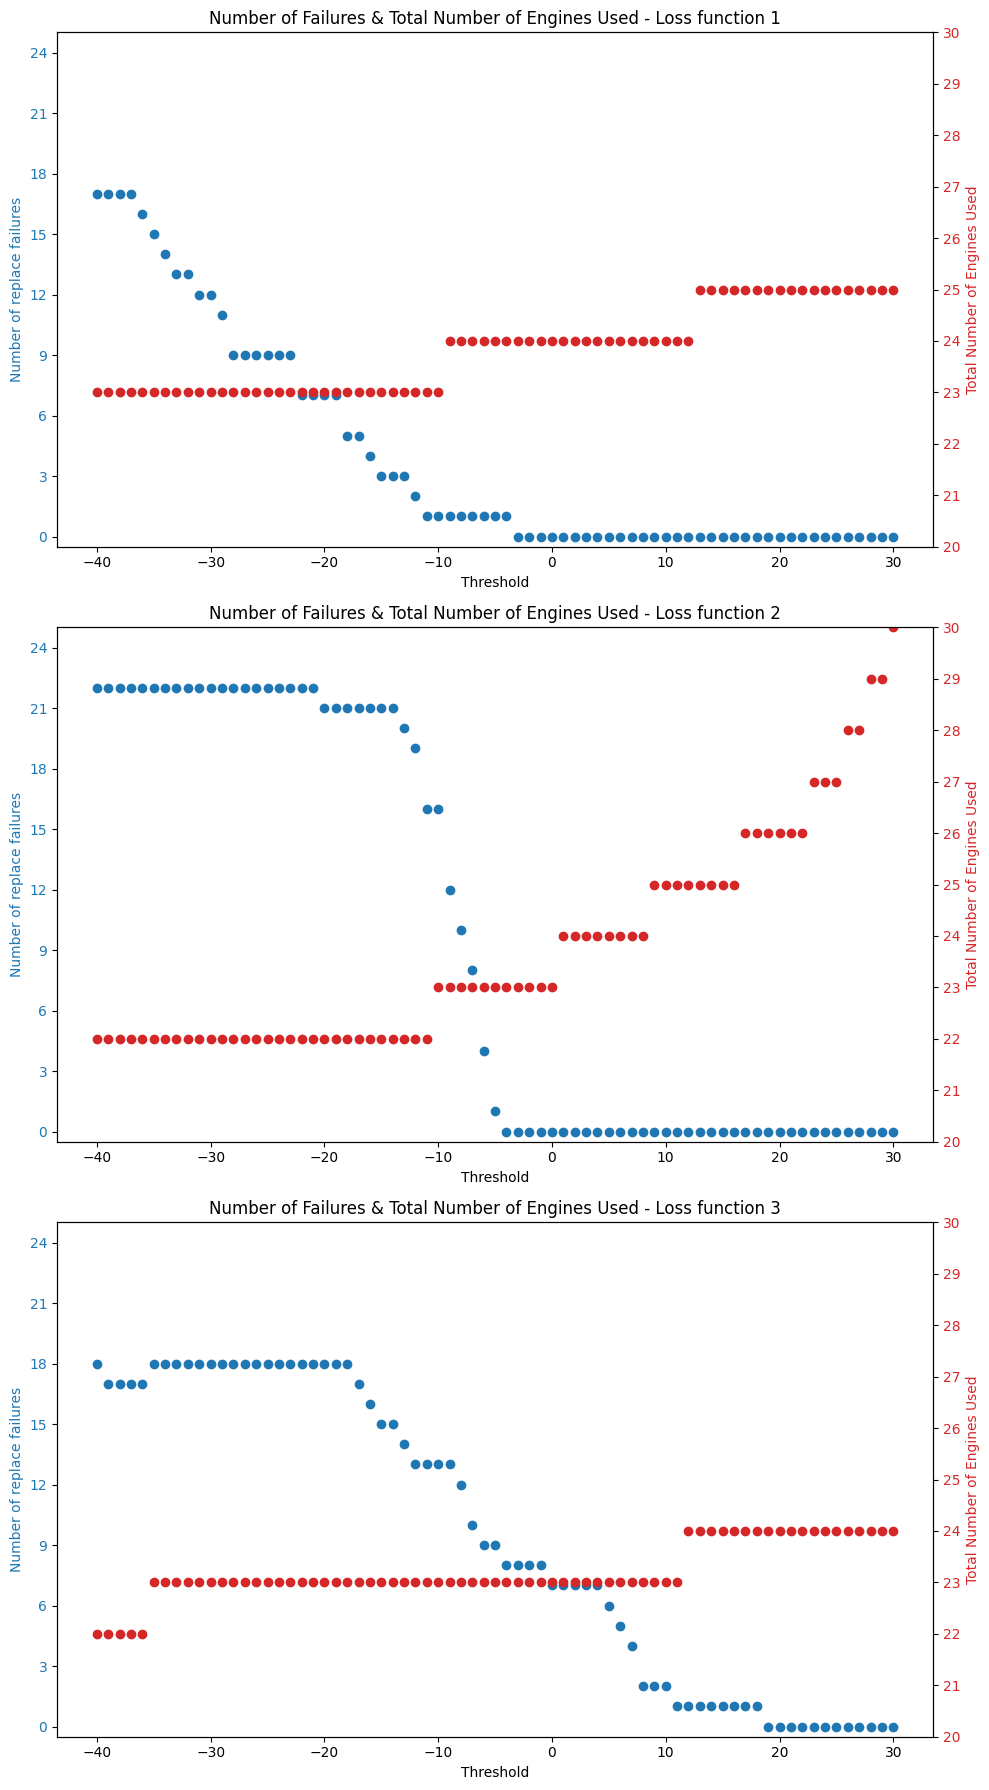

In [51]:
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-0.5,25)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(20,30)

    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

**Plot - Threshold에 따른 replace 실패 횟수와, 총 사용한 엔진 수**

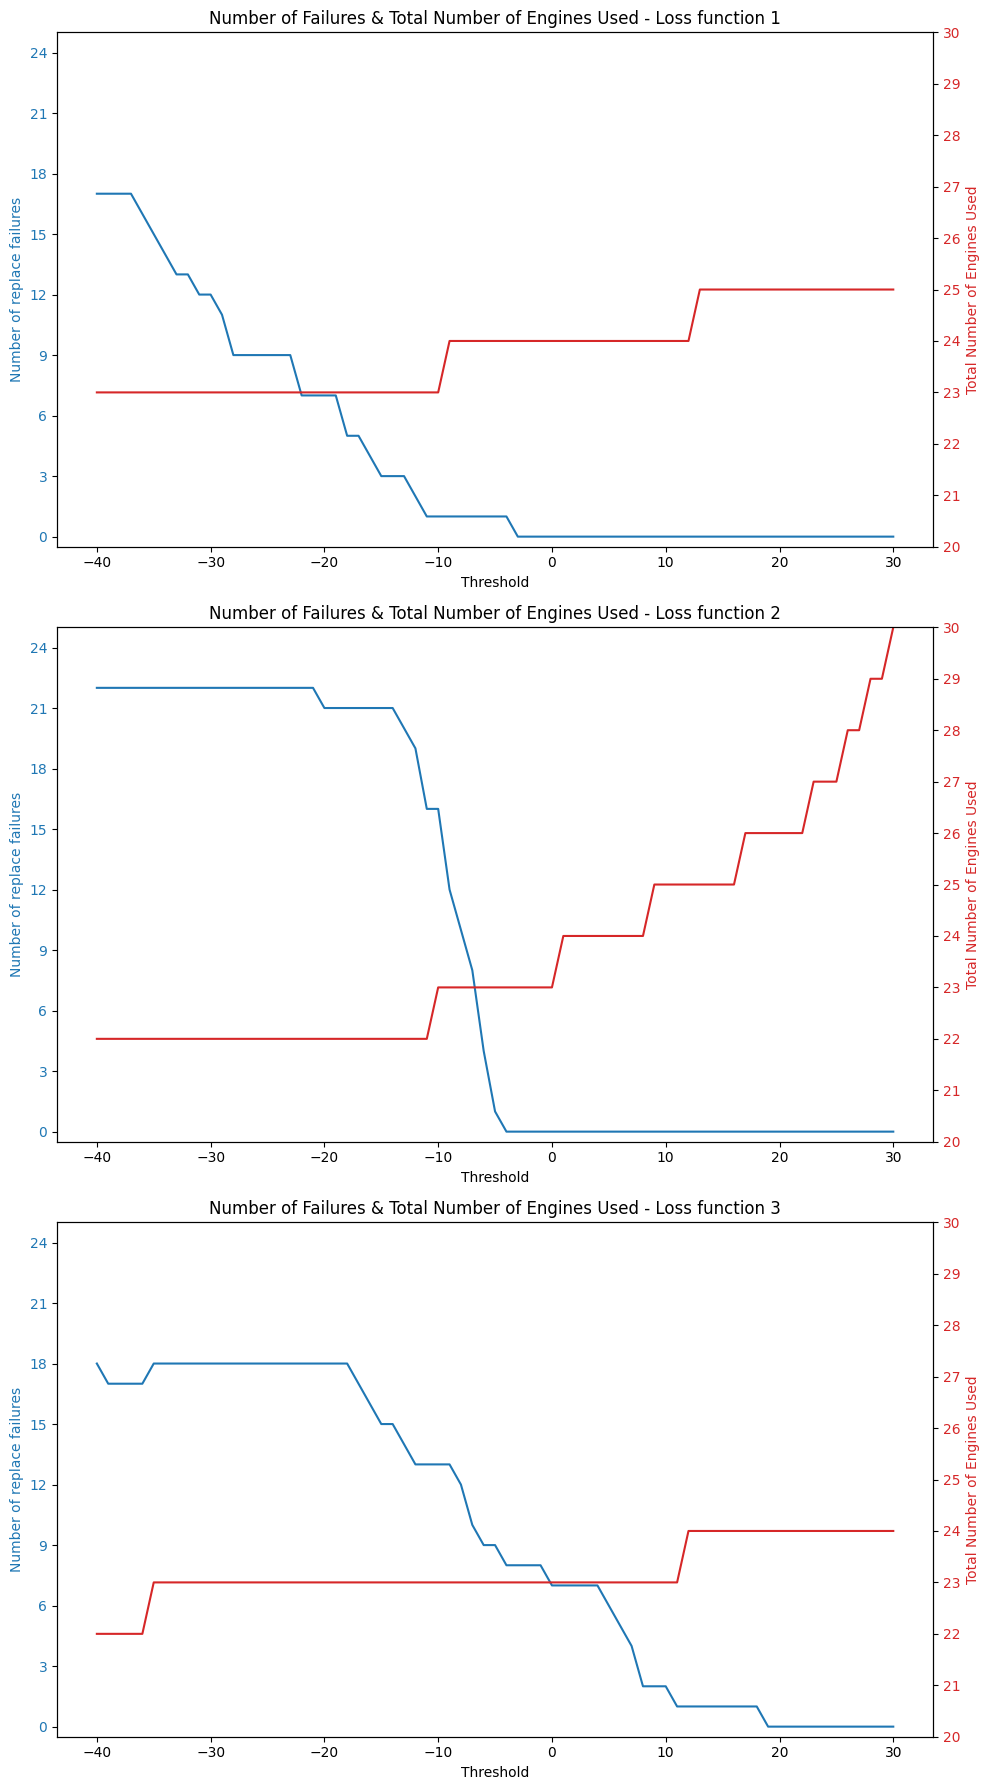

In [52]:
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-0.5,25)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(20,30)

    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

**Scatter plot - Total Cost & Total Number of Engines Used**

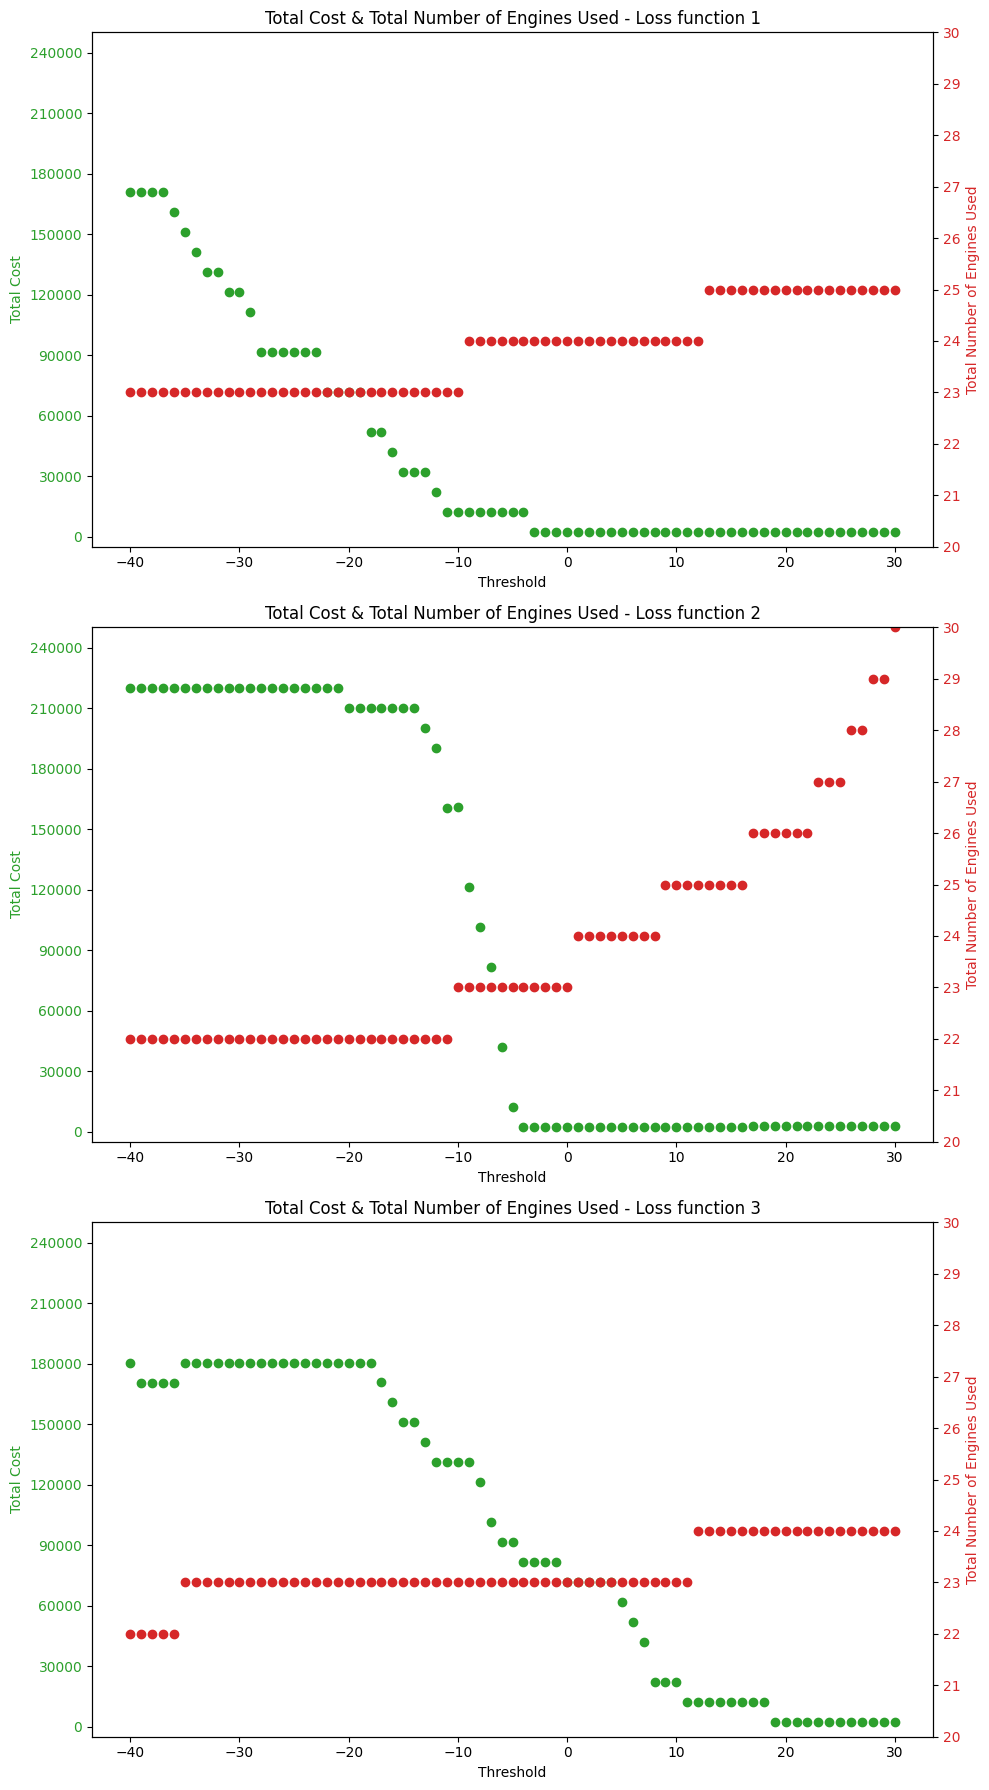

In [53]:
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost', color=color)
    ax1.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-5000,250000)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(20,30)

    # 그래프 제목 설정
    ax1.set_title(f'Total Cost & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

**Plot - Total Cost & Total Number of Engines Used**

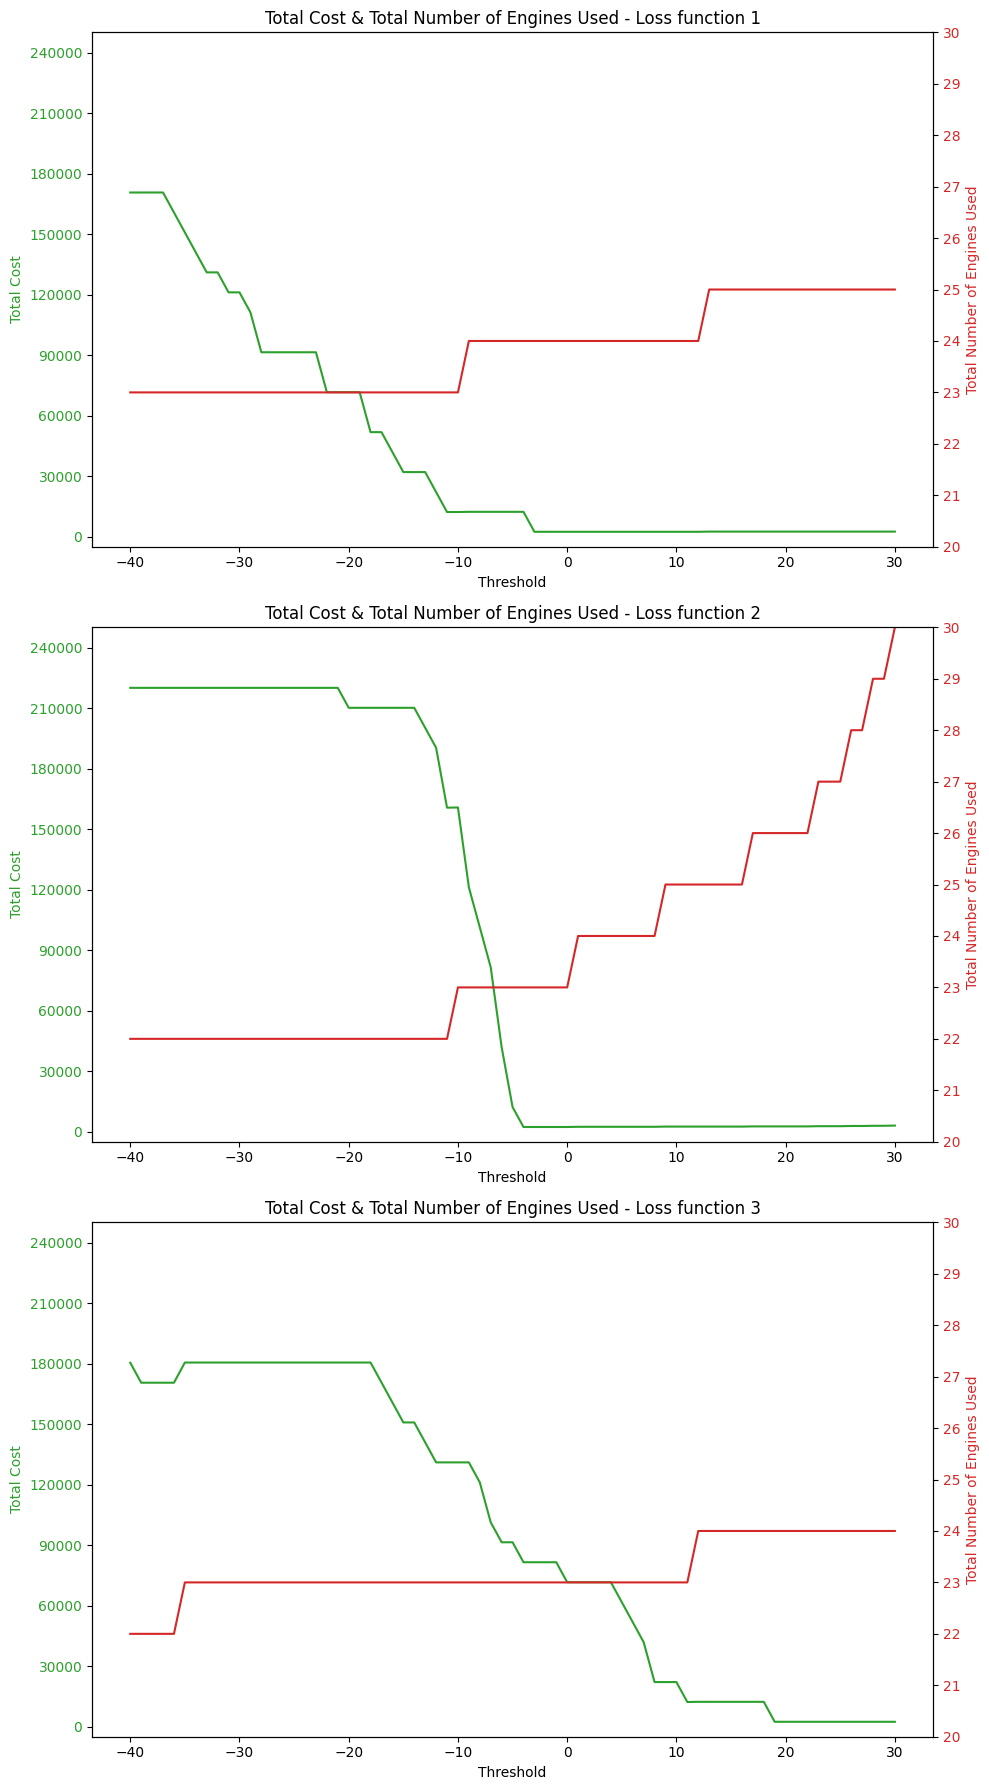

In [54]:
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Total Cost)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost', color=color)
    ax1.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-5000,250000)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(20,30)

    # 그래프 제목 설정
    ax1.set_title(f'Total Cost & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

**Scatter plot of Total Cost**

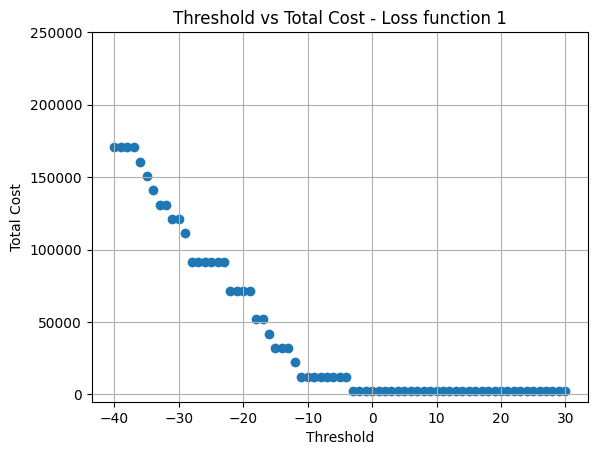

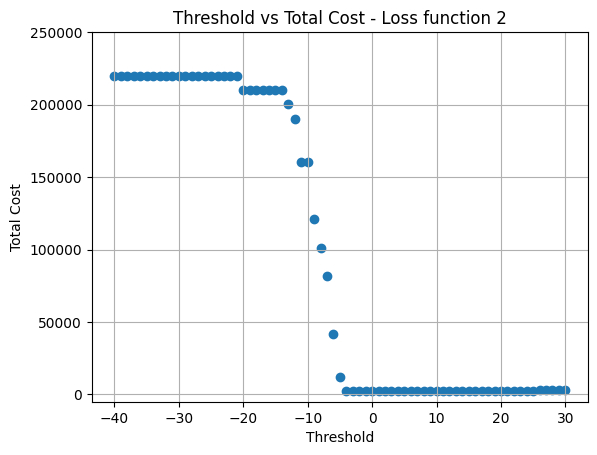

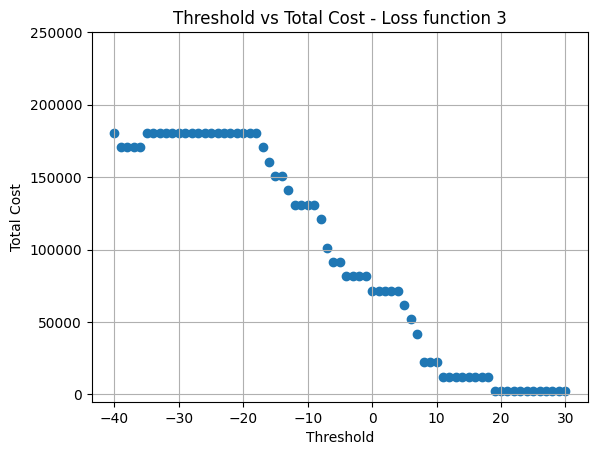

In [55]:
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    plt.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'])
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title(f'Threshold vs Total Cost - Loss function {i}')
    plt.grid(True)
    plt.ylim(-5000, 250000)
    plt.show()

**Plot of Total Cost**

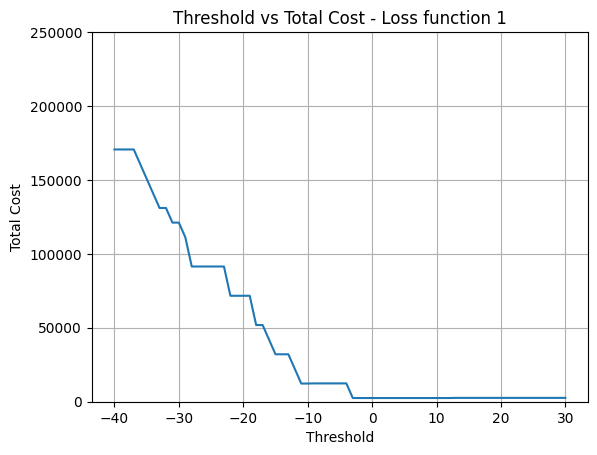

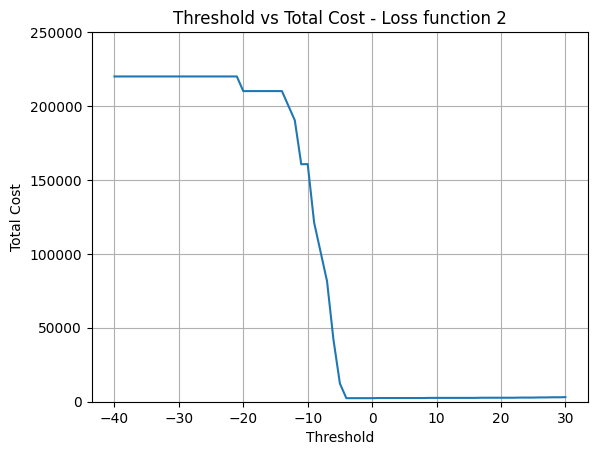

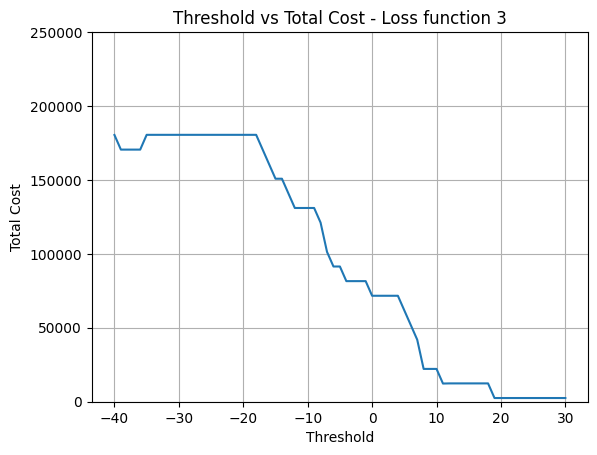

In [56]:
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    plt.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'])
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title(f'Threshold vs Total Cost - Loss function {i}')
    plt.grid(True)
    plt.ylim(-100, 250000)
    plt.show()

**Scatter plot - Threshold에 따른 replace 실패 횟수와, 총 사용한 엔진수 - Full data**

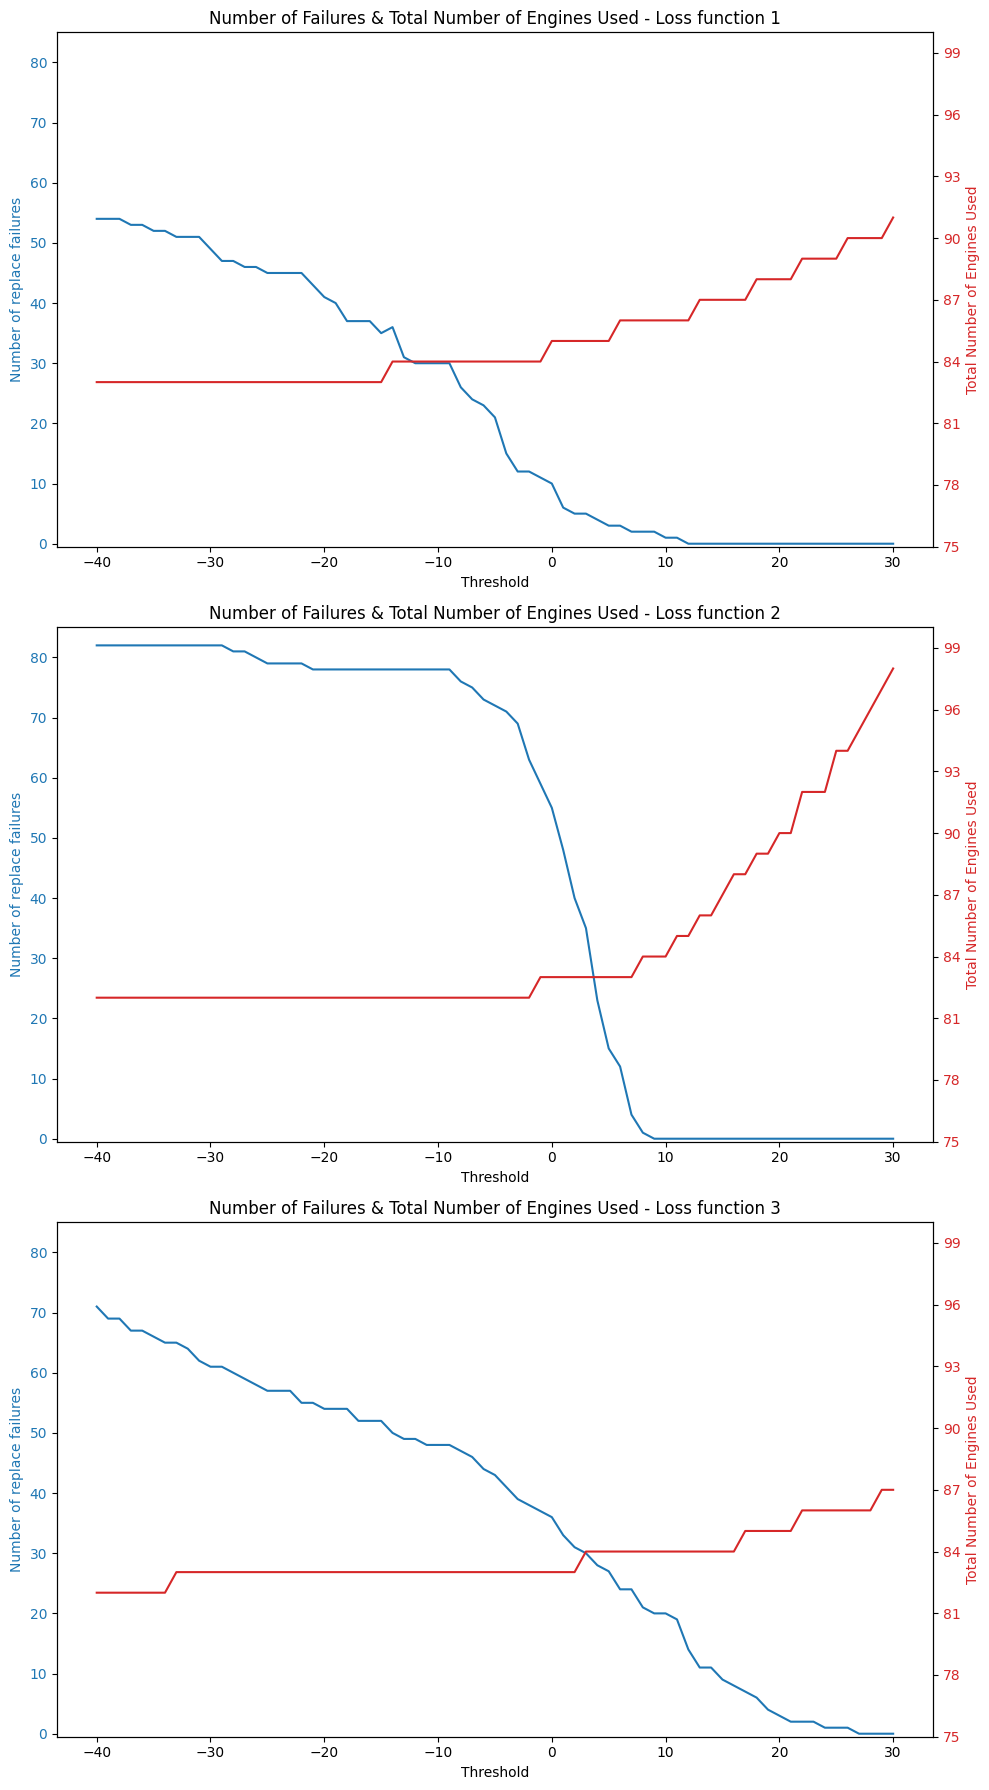

In [101]:
fig, axs = plt.subplots(len(full_nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(full_nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-0.5,85)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(75,100)

    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

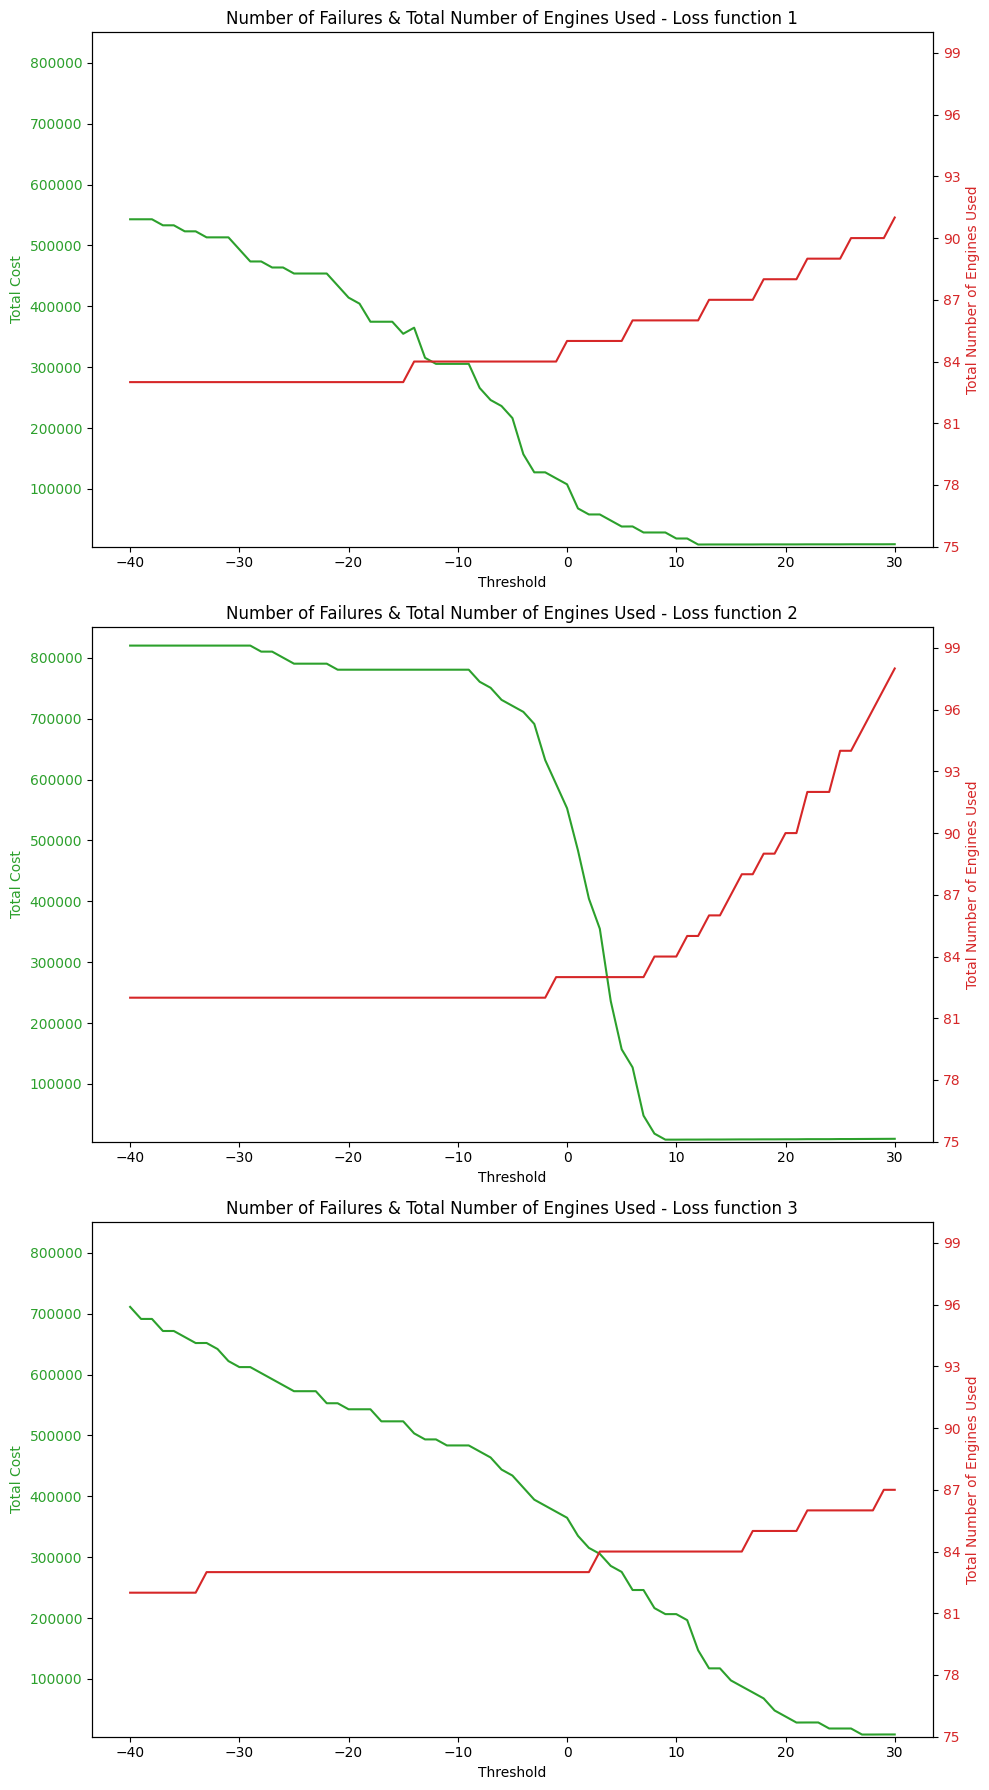

In [102]:
fig, axs = plt.subplots(len(full_nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(full_nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Total Cost)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost', color=color)
    ax1.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(5000,850000)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(75,100)

    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

# Policy-based RL (REINFORCE Algorithm)

Stochastic policy version

In [57]:
# Train dataset을 적절히 나눠서 Train, Test를 진행 (RUL prediction에서는 70:30 적용했음).
# Train dataset에서 unit을 변경하며 cumulative reward의 최대화 수행.

# Time cycle 10,000 (혹은 1,000)으로 고정해서 RL을 적용 (Threshold도 함께 학습)
# Threshold를 학습하려면 REINFORE Alg. 같은 stochastic policy가 아니라, Deterministic Policy based RL style로 가야하지 않을까?
# Deterministic policy based로 다시 생각해보자.
# Deterministic policy Gradient Algorithm (DPG; 2014)



Importing libraries (RL)

REINFORCE Algorithm

In [58]:
# policy control parameter theta, y_bar (threshold도 학습의 대상으로 parameter에 들어감)